# Task 2 Results Figure
Kai Sandbrink

2024-03-11

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from utils import format_axis

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from utils import flatten

analysis_folder = os.path.join('panels', 'fig_task2')
os.makedirs(analysis_folder, exist_ok=True)

## Panel A: Single-Episode Sleeps
### General Options

In [2]:
effs_to_plot = [1, 0.5, 0]
n_steps = 50
smoothing_window = 4
ylim = (-0.01,0.45)

exp_date = '24-01-22-29'
human_data_file_base = '..' # make sure the cwd points to the root repo folder, else adjust here

### Humans

In [3]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [4]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
sleeps = [transitions_test[0][:,3], transitions_test[1][:,2], transitions_test[0][:,0]] ## plotting highest efficacy first
sleeps = [sleep == -1 for sleep in sleeps]

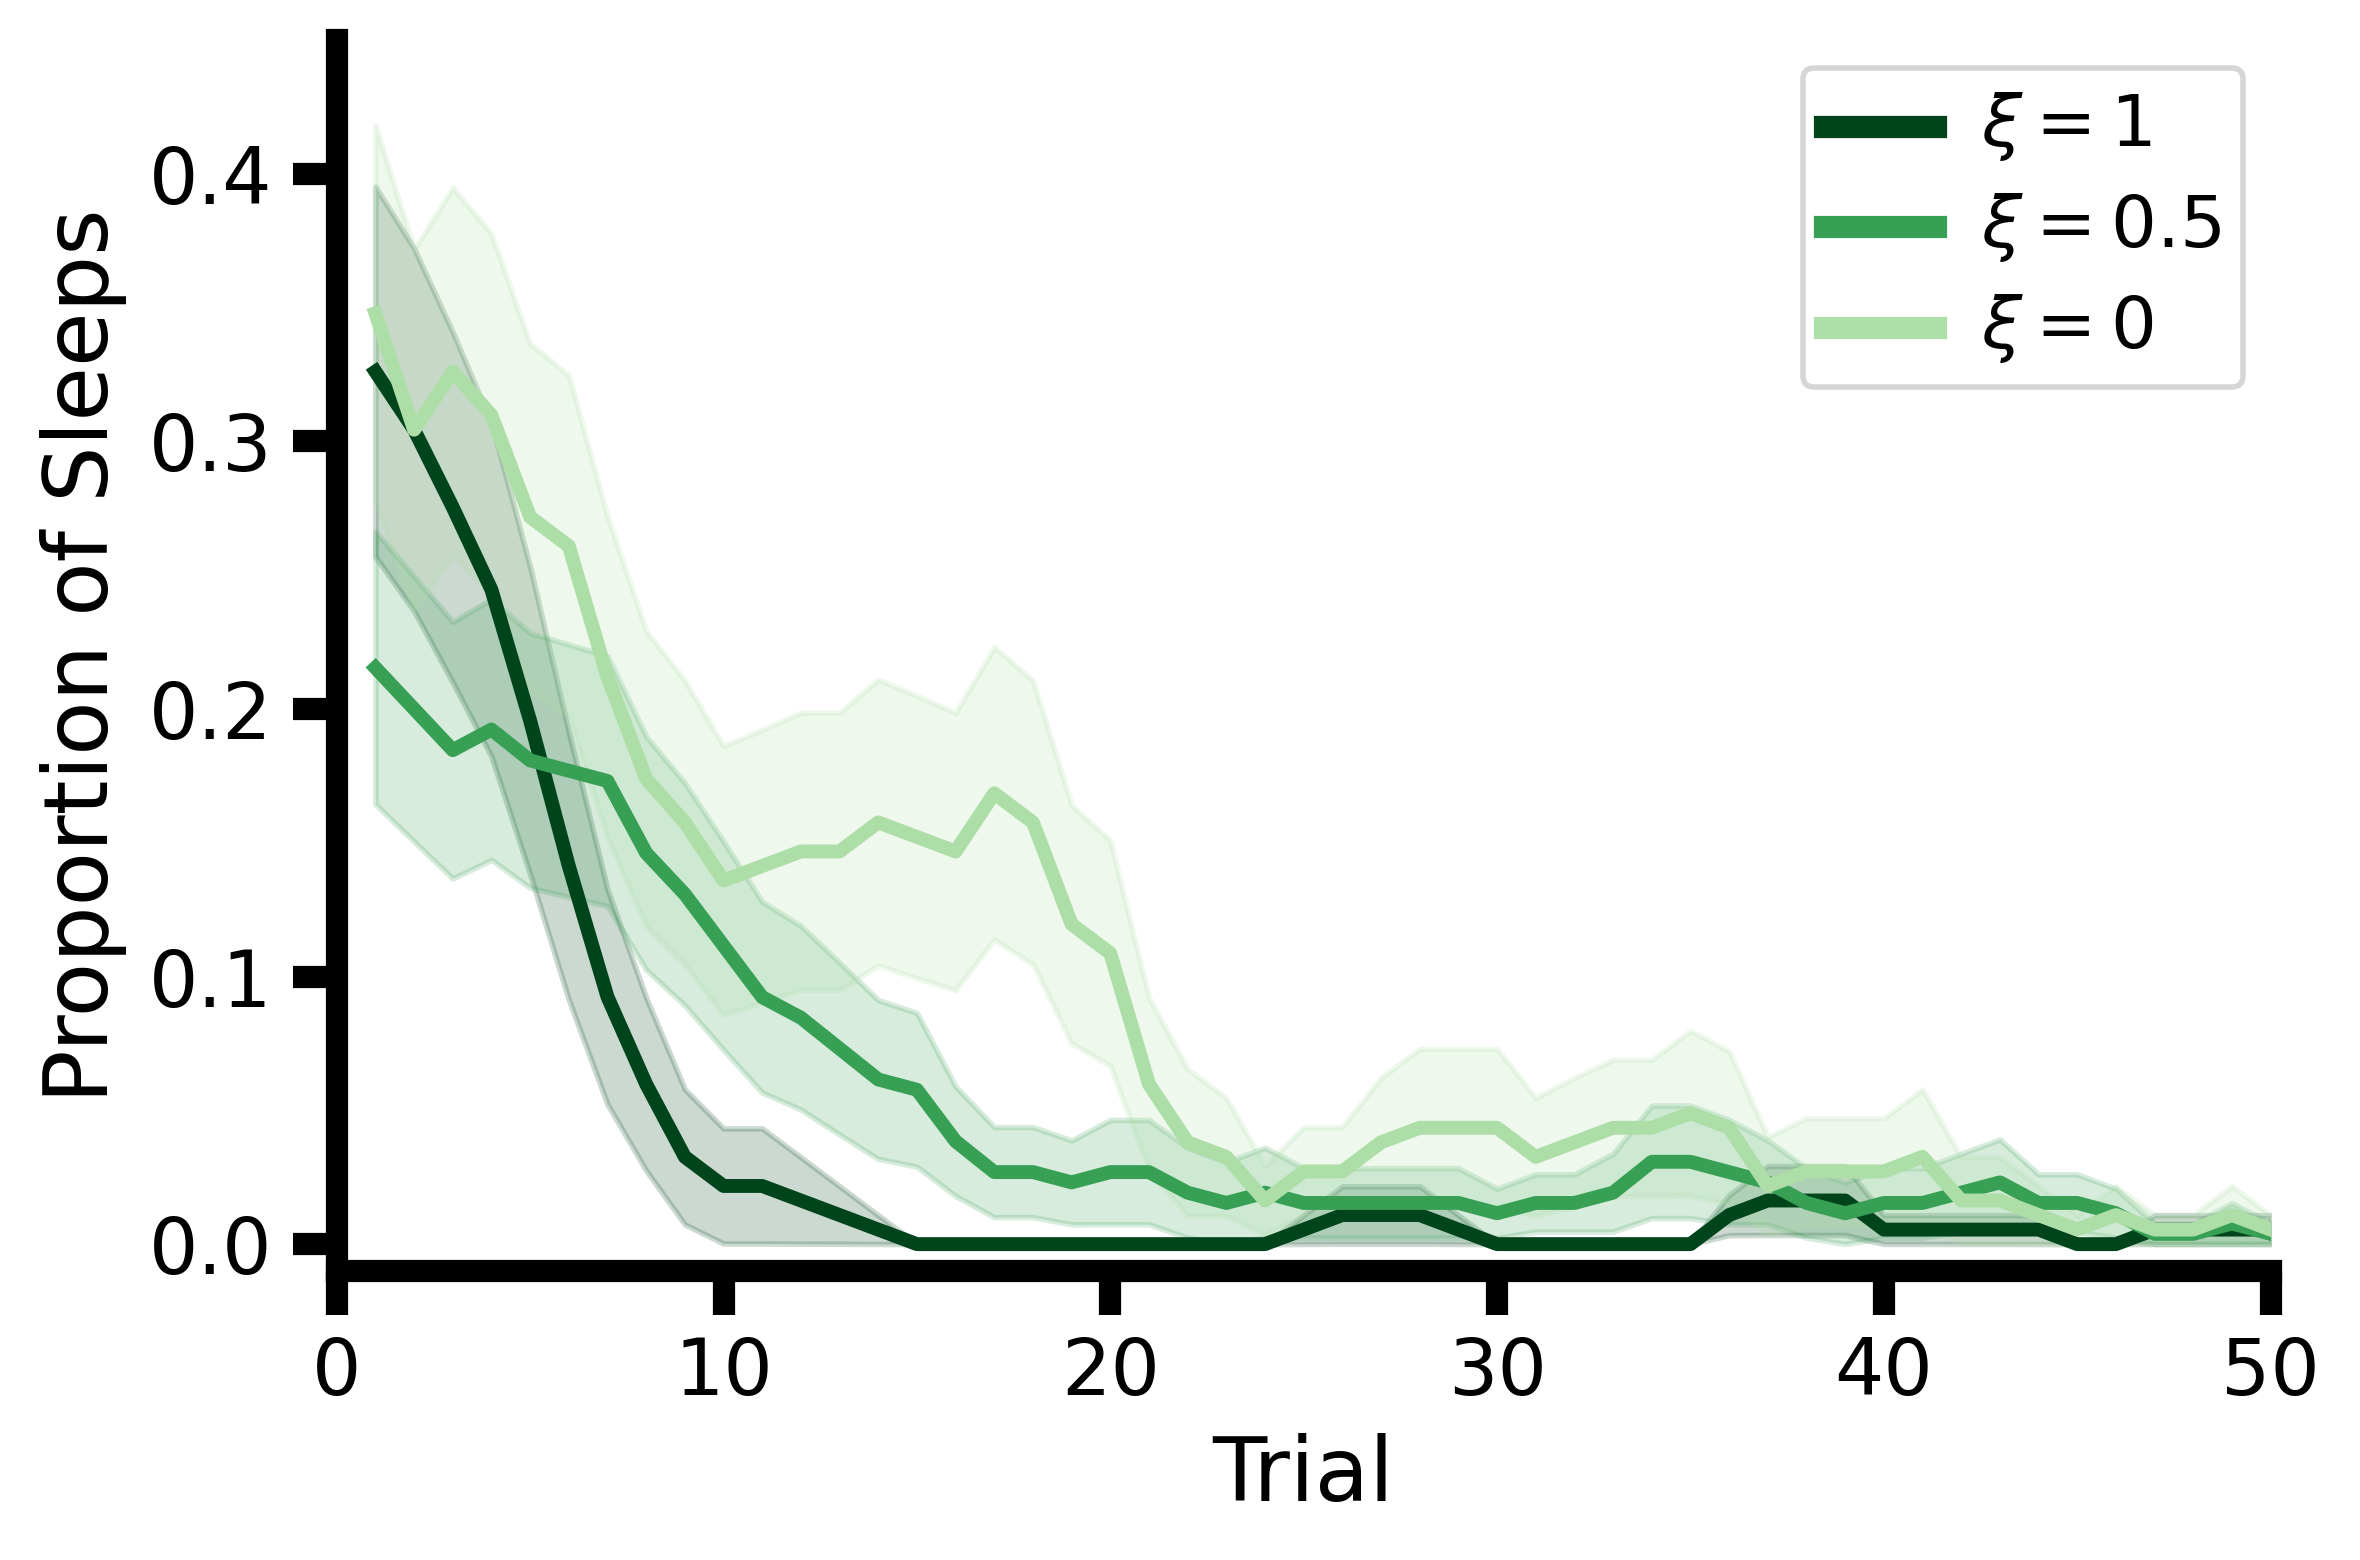

In [5]:
mean_probs = np.array([np.nanmean(sleep, axis=0) for sleep in sleeps])
stderr_probs = np.array([np.nanstd(sleep, axis=0)/np.sqrt(sleep.shape[0]) for sleep in sleeps])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1, mean_probs.shape[1]+1)

for i in range(len(mean_probs)):
    ax.plot(steps, mean_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

ax.legend()

ax.set_xlabel("Trial")
ax.set_ylabel("Proportion of Sleeps")

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0,50)

format_axis(ax)

plt.tight_layout()


In [6]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_humans.svg'))

#### Stats

In [7]:
cropped_sleeps = [np.nanmean(sleep[:,8:20], axis=1) for sleep in sleeps]
plotted_levels = [1, 0.5, 0]

In [8]:
## MEANS AND SEMS
for level, sleep in zip(plotted_levels, cropped_sleeps):
    print("Test Controllability ", level)
    print("Mean ", sleep.mean())
    print("StdErr ", sleep.std()/np.sqrt(sleep.shape[0]))
    print("N", sleep.shape[0])

Test Controllability  1
Mean  0.005434782608695652
StdErr  0.003970801189198951
N 46
Test Controllability  0.5
Mean  0.05
StdErr  0.010695719802366261
N 65
Test Controllability  0
Mean  0.13405797101449274
StdErr  0.020088000329310914
N 46


In [9]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_sleeps)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_sleeps), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0    0.5  -0.0841    0.0 -0.1271  -0.041   True
   0.0    1.0  -0.1286    0.0 -0.1752 -0.0821   True
   0.5    1.0  -0.0446 0.0404 -0.0876 -0.0015   True
----------------------------------------------------


In [10]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_sleeps')
glm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:              MixedLM   Dependent Variable:   n_sleeps  
No. Observations:   999       Method:               REML      
No. Groups:         111       Scale:                2.8097    
Min. group size:    9         Log-Likelihood:       -2059.7559
Max. group size:    9         Converged:            Yes       
Mean group size:    9.0                                       
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           4.628    0.269  17.225 0.000  4.101  5.155
C(group_C)[T.True] -0.302    0.334  -0.904 0.366 -0.957  0.353
efficacy           -3.575    0.164 -21.755 0.000 -3.897 -3.253
Group Var           2.698    0.258                            
==============================================================

"""

### APE-trained Neural Networks

In [11]:
from settings_ana import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

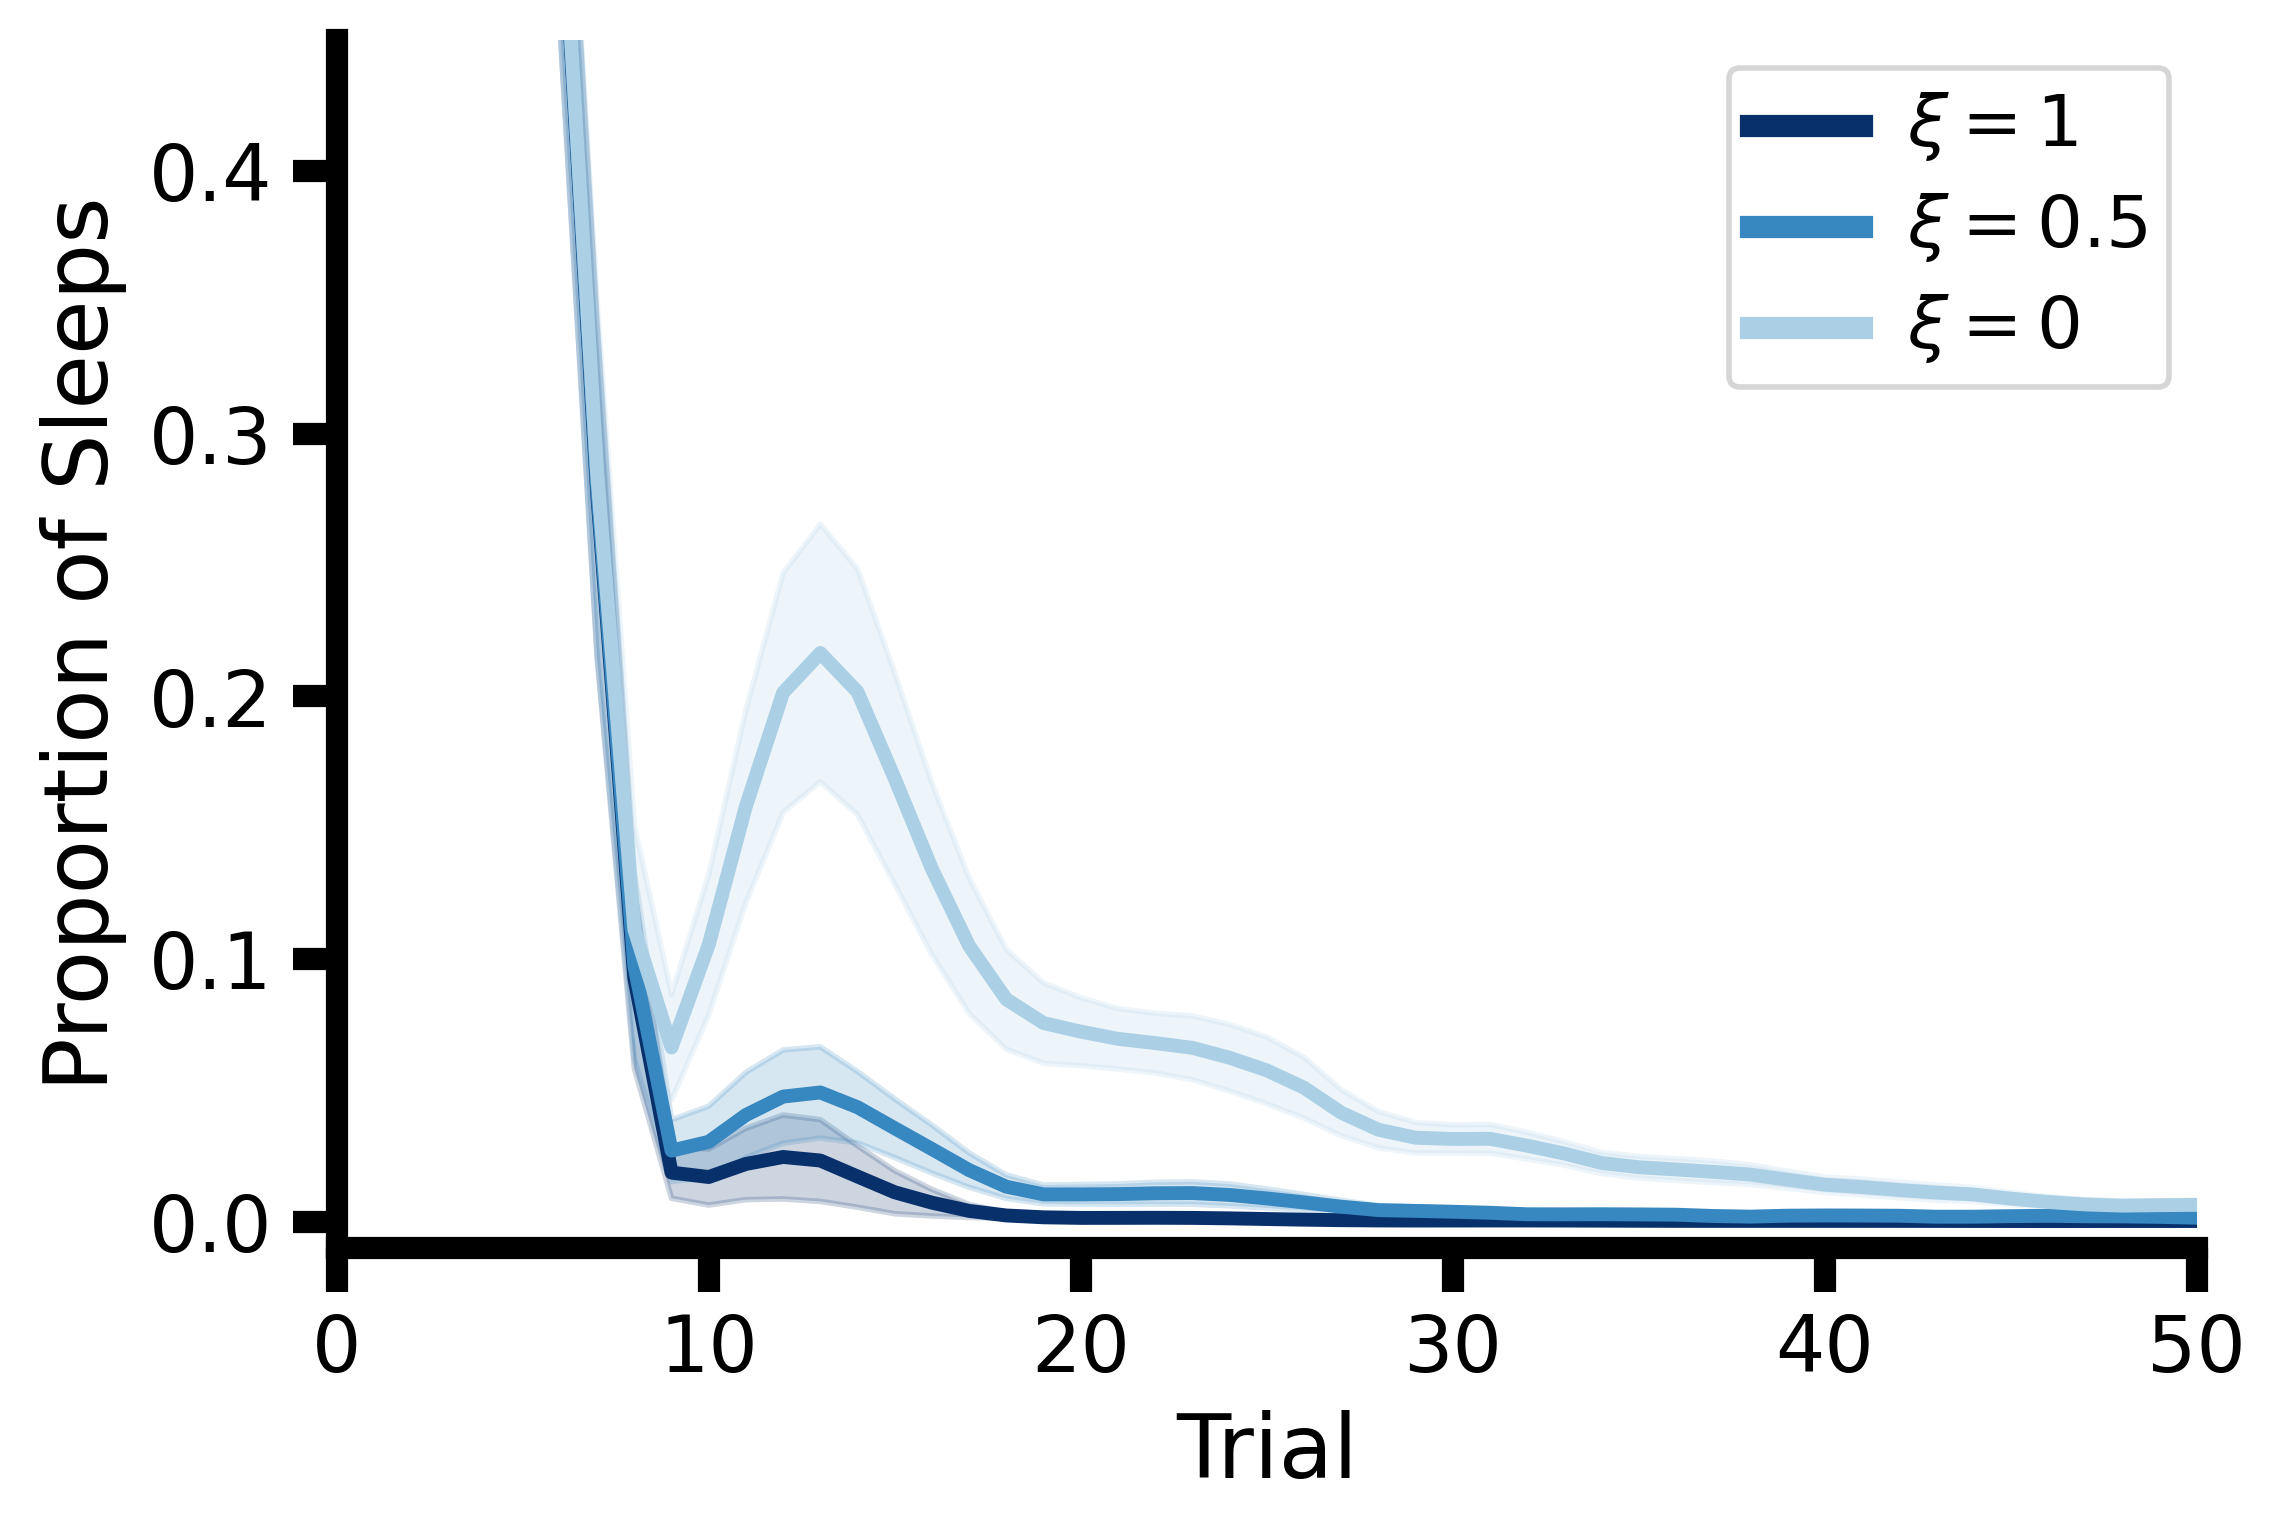

In [12]:
from test_analyses import frac_sleeps_lineplot

fig = frac_sleeps_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Sleeps")

In [22]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_apes.svg'))

### No APE Networks

In [13]:
from settings_ana import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

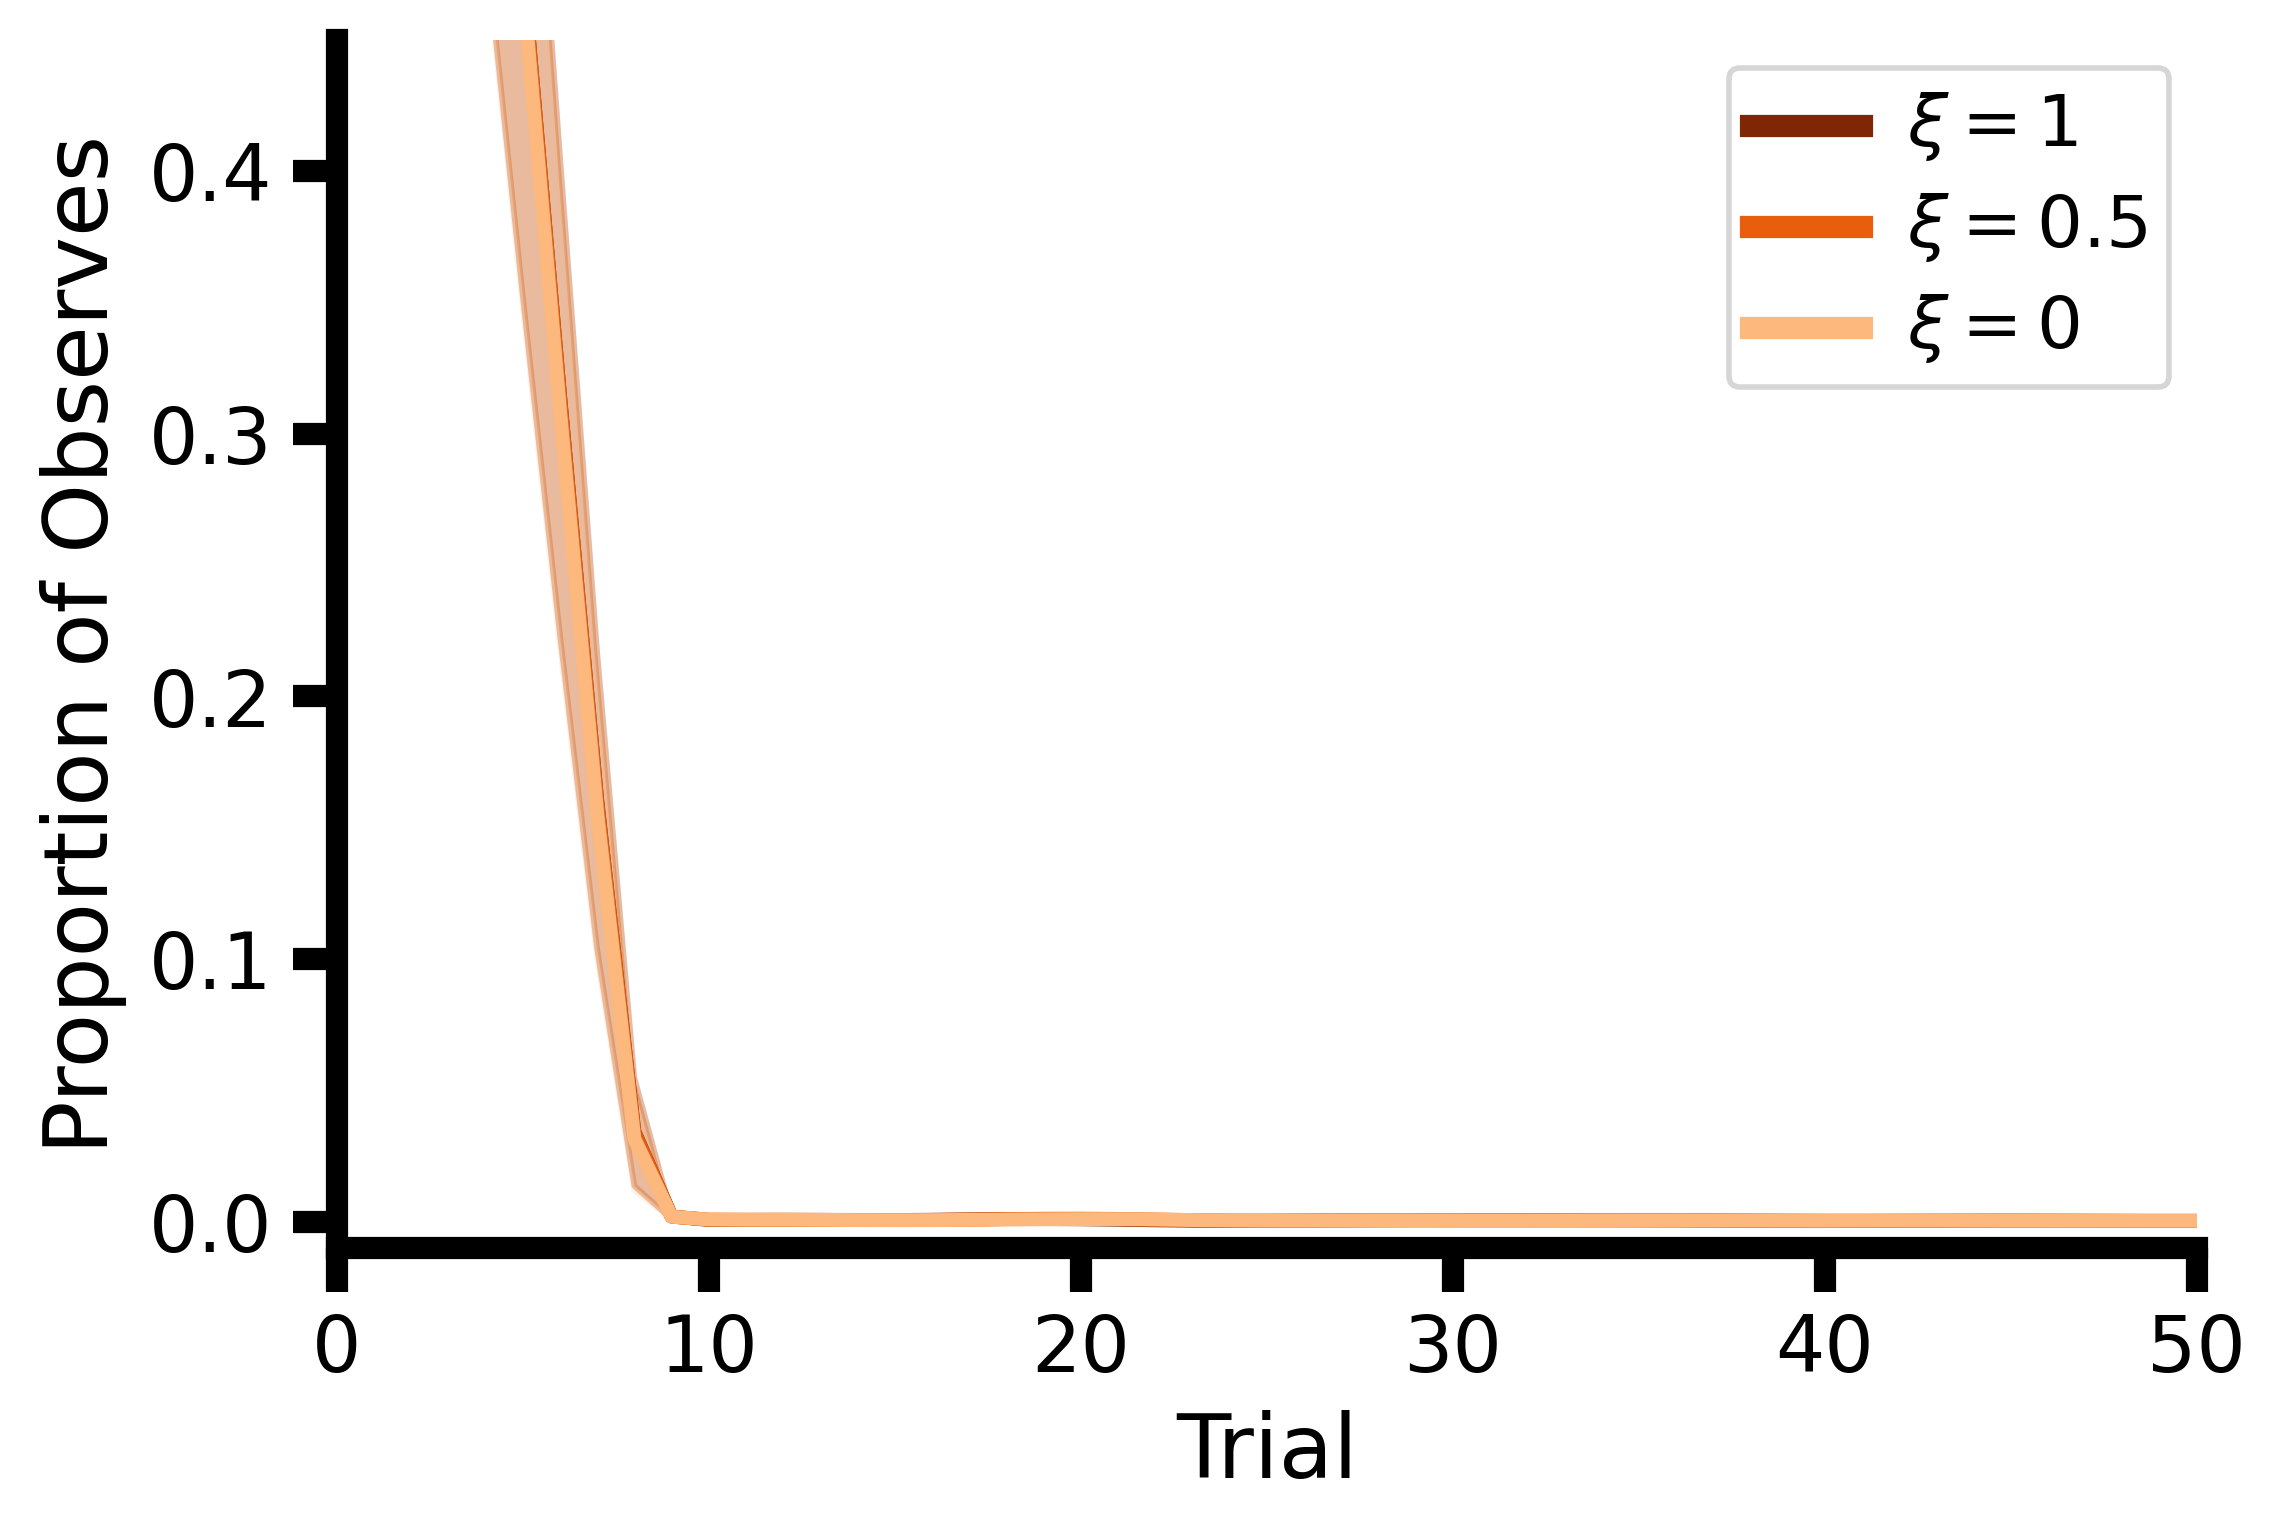

In [16]:
from test_analyses import frac_sleeps_lineplot

fig = frac_sleeps_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [17]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_episode_noape.svg'))

## Panel B: Single-Episode Observations
### General Options

In [18]:
effs_to_plot = [1, 0.5, 0]
n_steps = 50
smoothing_window = 8
ylim = (-0.01, 0.3)

### Humans

In [19]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [20]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
observations = [transitions_test[0][:,3], transitions_test[1][:,2], transitions_test[0][:,0]] ## plotting highest efficacy first
observations = [observation == 0.5 for observation in observations]

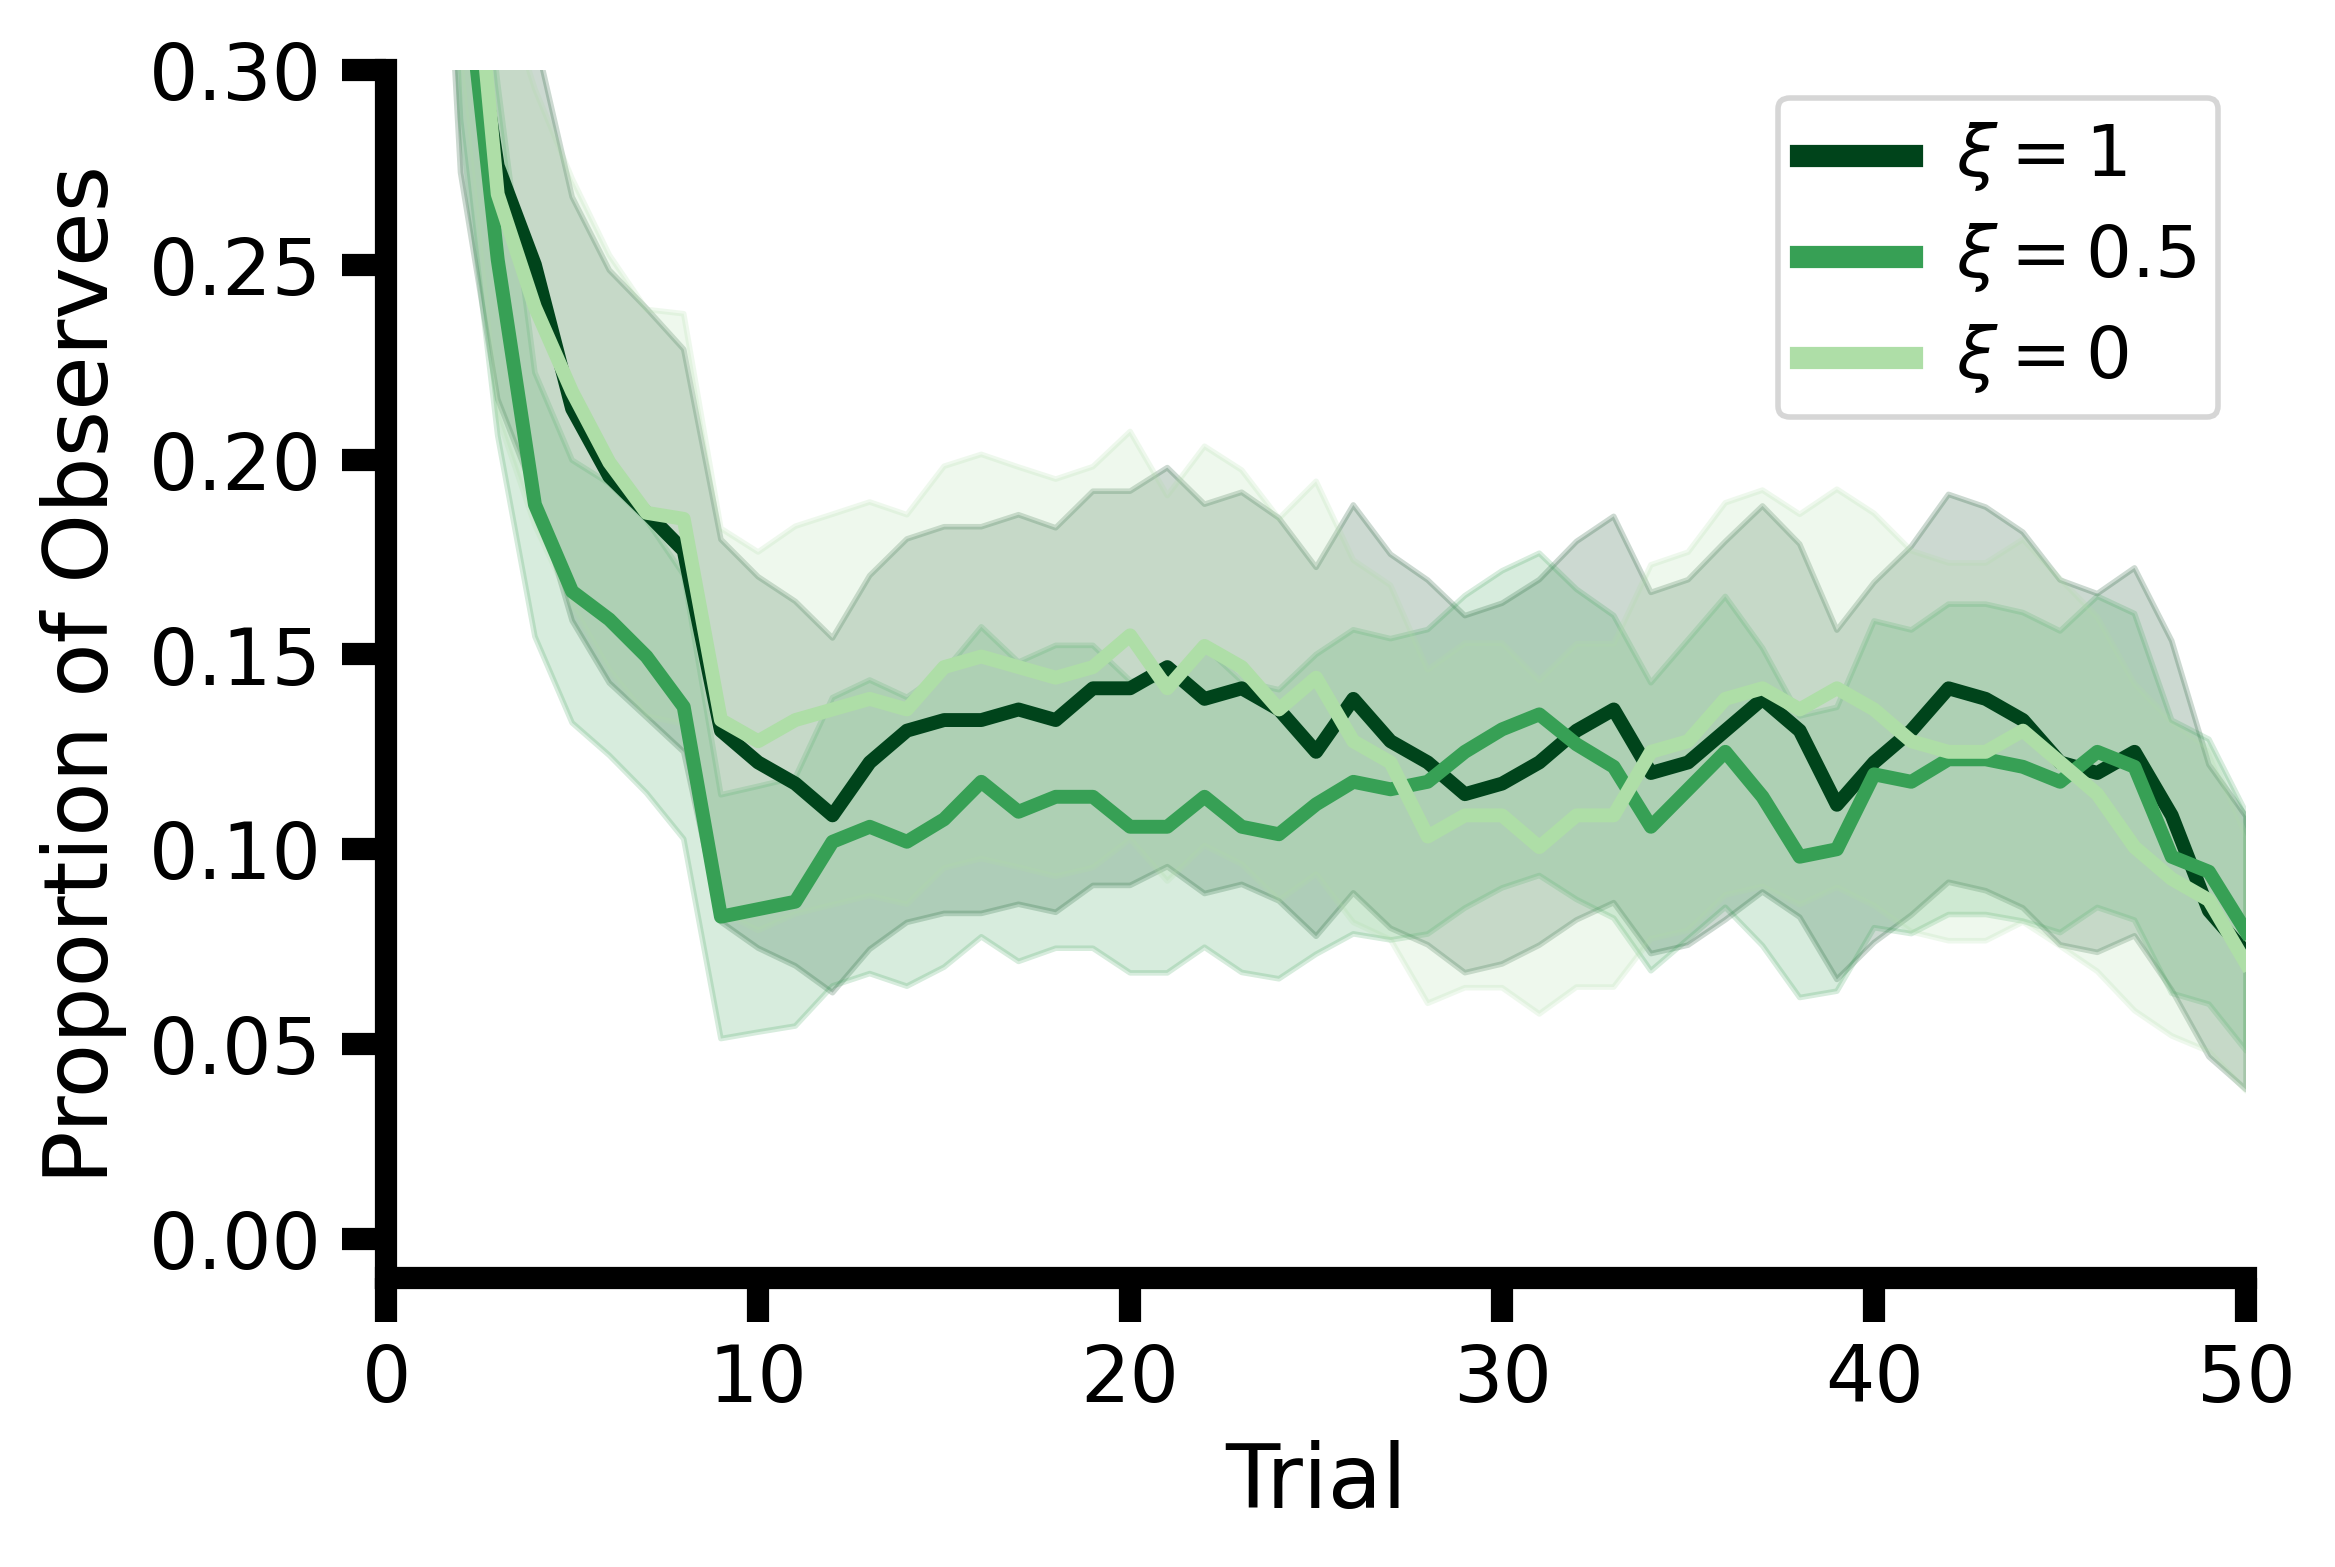

In [22]:
mean_peek_probs = np.array([observation.mean(axis=0) for observation in observations])
stderr_peek_probs = np.array([observation.std(axis=0)/np.sqrt(observation.shape[0]) for observation in observations])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_peek_probs = pd.DataFrame(mean_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_peek_probs = pd.DataFrame(stderr_peek_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1,mean_peek_probs.shape[1]+1)

for i in range(len(mean_peek_probs)):
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    #ax.plot(steps, mean_peek_probs[i], label=effs_to_plot[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.plot(steps, mean_peek_probs[i], label=r"$\xi=$" + str(effs_to_plot[i]), color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)))
    ax.fill_between(steps, mean_peek_probs[i] - stderr_peek_probs[i], mean_peek_probs[i] + stderr_peek_probs[i], color=cmap_humans((len(mean_peek_probs) - i)/len(mean_peek_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title="Efficacy")
ax.legend()

ax.set_xlabel("Trial")
ax.set_ylabel("Proportion of Observes")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0,50)

format_axis(ax)

In [23]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_humans.svg'))

#### Stats

In [24]:
cropped_observations = [observation[:,15:].mean(axis=1) for observation in observations]
plotted_levels = [1, 0.5, 0]

In [25]:
## MEANS AND SEMS
for level, obs in zip(plotted_levels, cropped_observations):
    print("Test Controllability ", level)
    print("Mean ", obs.mean())
    print("StdErr ", obs.std()/np.sqrt(obs.shape[0]))
    print("N", obs.shape[0])

Test Controllability  1
Mean  0.11801242236024848
StdErr  0.009606617498700929
N 46
Test Controllability  0.5
Mean  0.10725274725274725
StdErr  0.009966120979990702
N 65
Test Controllability  0
Mean  0.11490683229813664
StdErr  0.011093144416339643
N 46


In [26]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, cropped_observations)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(cropped_observations), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    0.5  -0.0077 0.8583  -0.042 0.0267  False
   0.0    1.0   0.0031 0.9787 -0.0341 0.0403  False
   0.5    1.0   0.0108 0.7397 -0.0236 0.0451  False
---------------------------------------------------


In [27]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'n_observes')
glm.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  n_observes
No. Observations:    999      Method:              REML      
No. Groups:          111      Scale:               2.5760    
Min. group size:     9        Log-Likelihood:      -2082.5541
Max. group size:     9        Converged:           Yes       
Mean group size:     9.0                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           6.110    0.456 13.405 0.000  5.217  7.004
C(group_C)[T.True] -0.824    0.587 -1.405 0.160 -1.974  0.326
efficacy            0.321    0.157  2.038 0.042  0.012  0.629
Group Var           8.986    0.829                           
=============================================================

"""

### APE-trained Neural Networks

In [28]:
from settings_ana import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

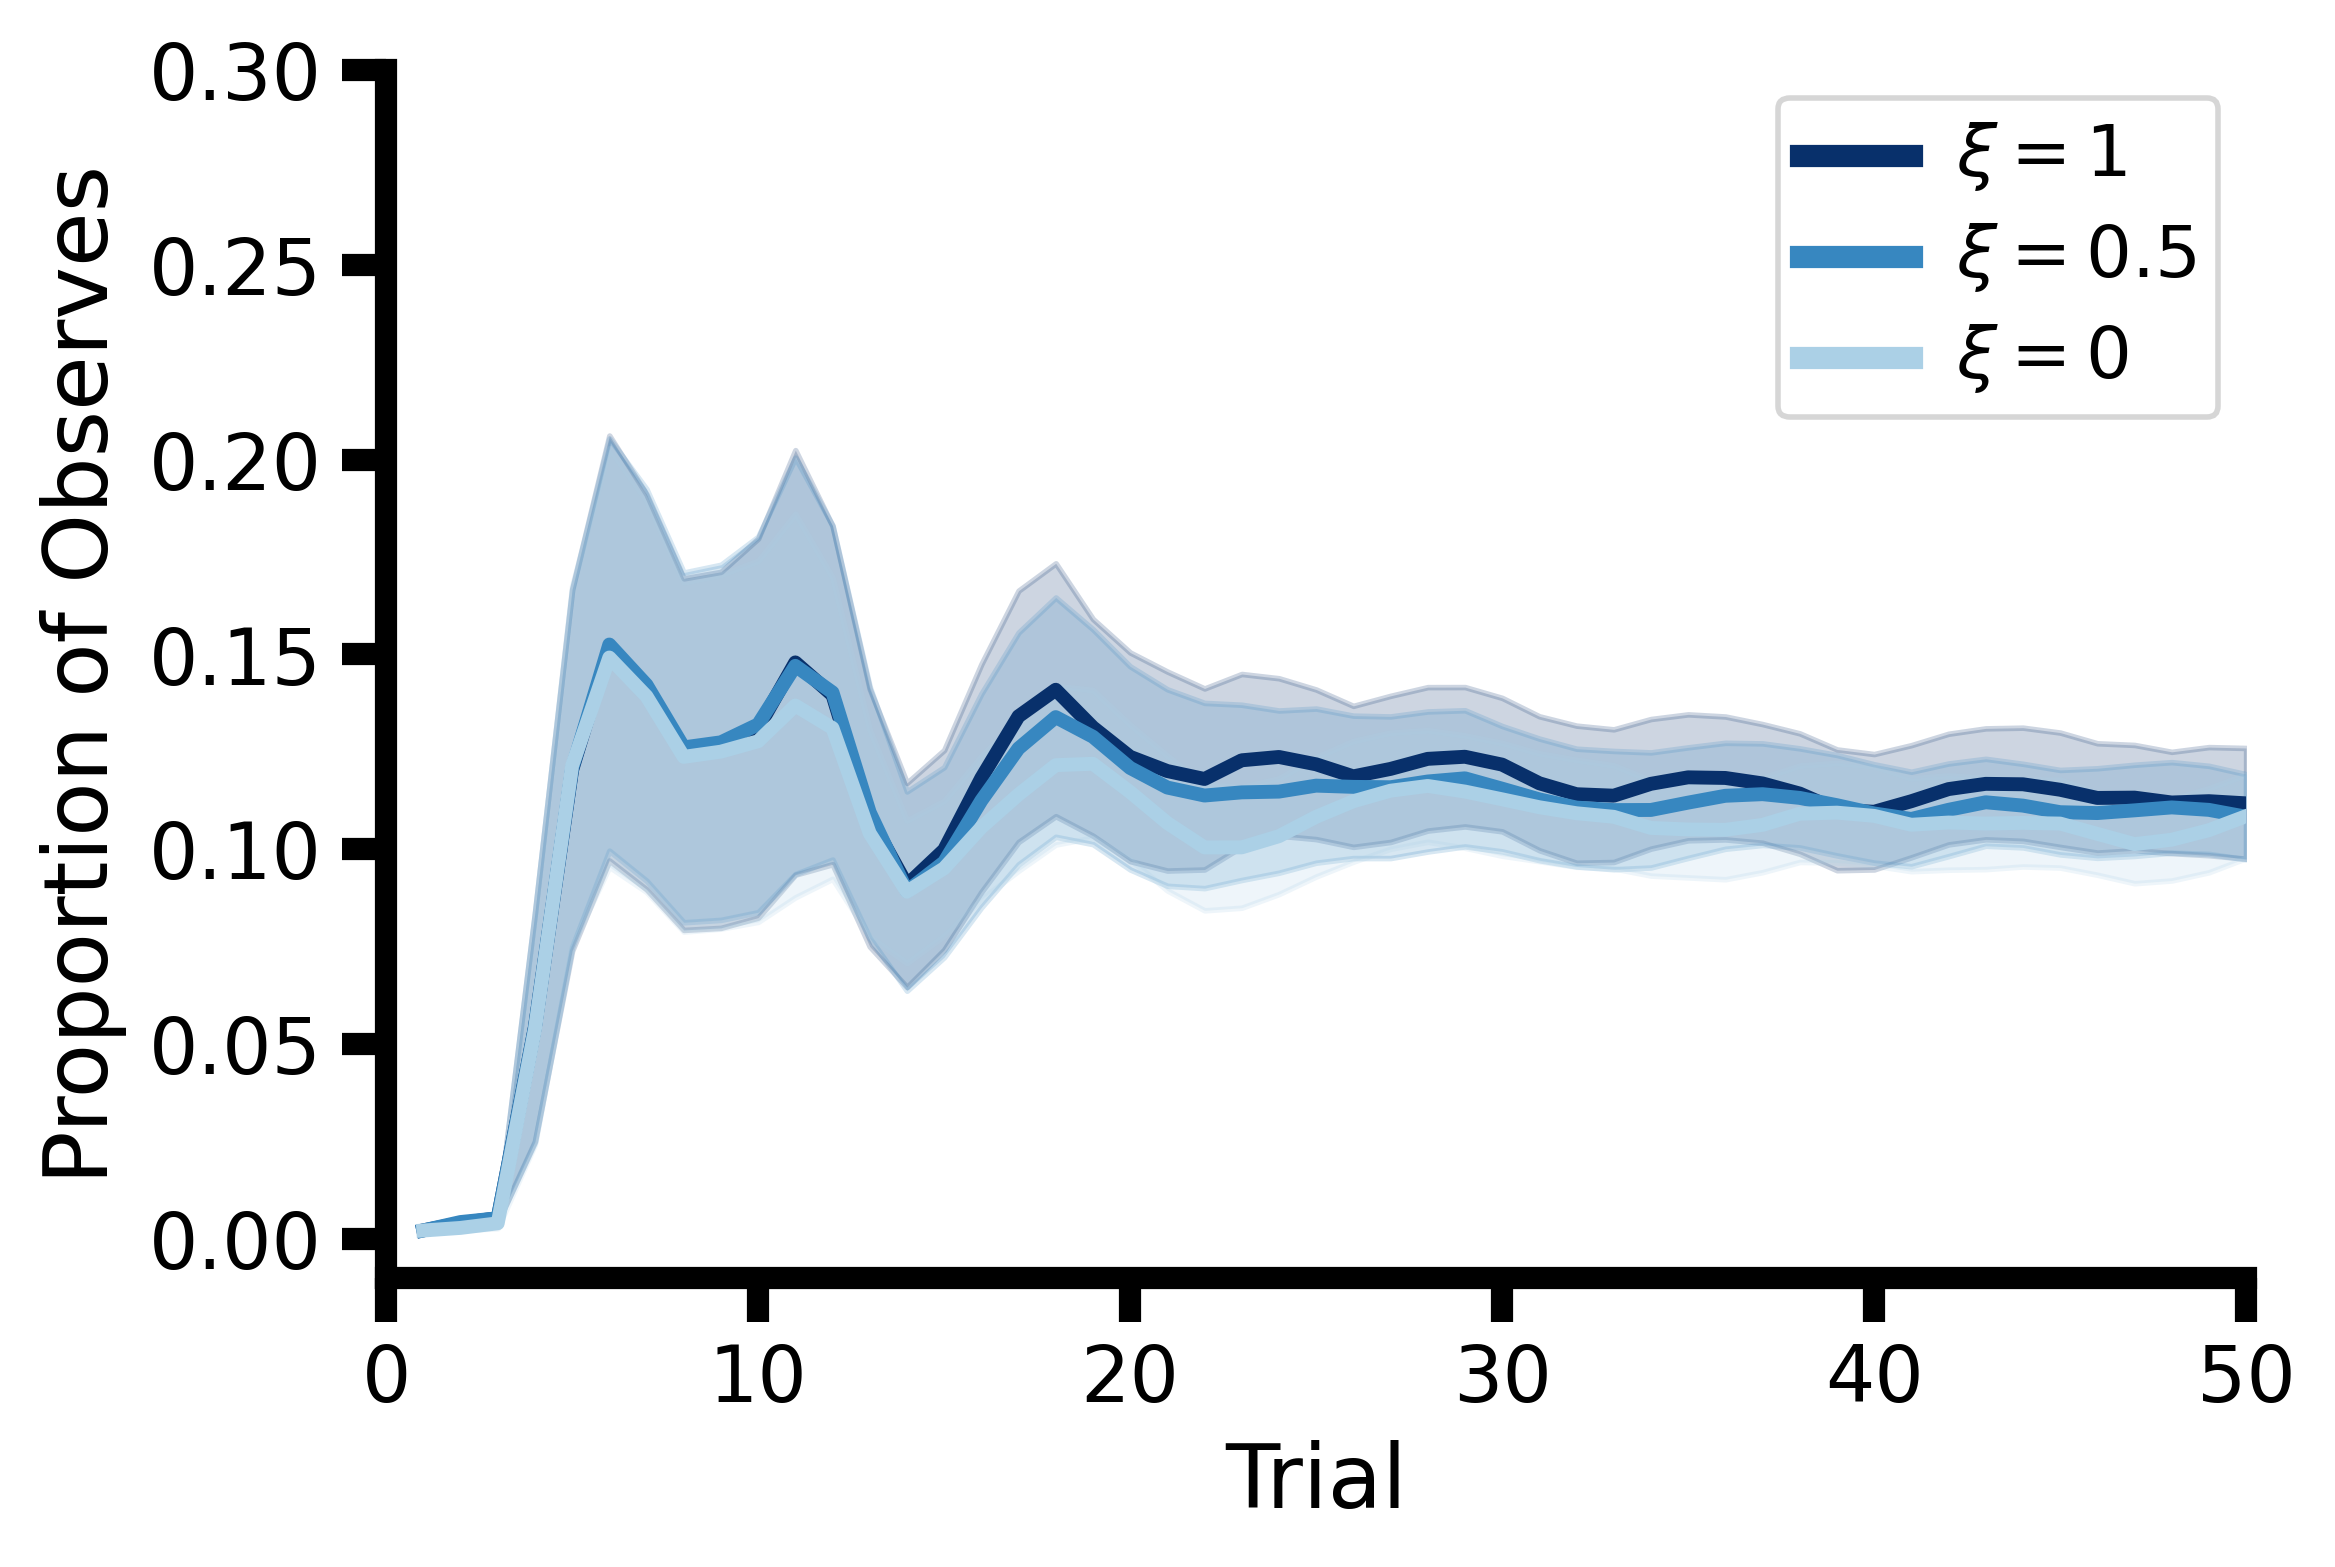

In [29]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Proportion of Observes")

In [30]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_ape.svg'))

### No-APE Neural Networks

In [31]:
from settings_ana import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

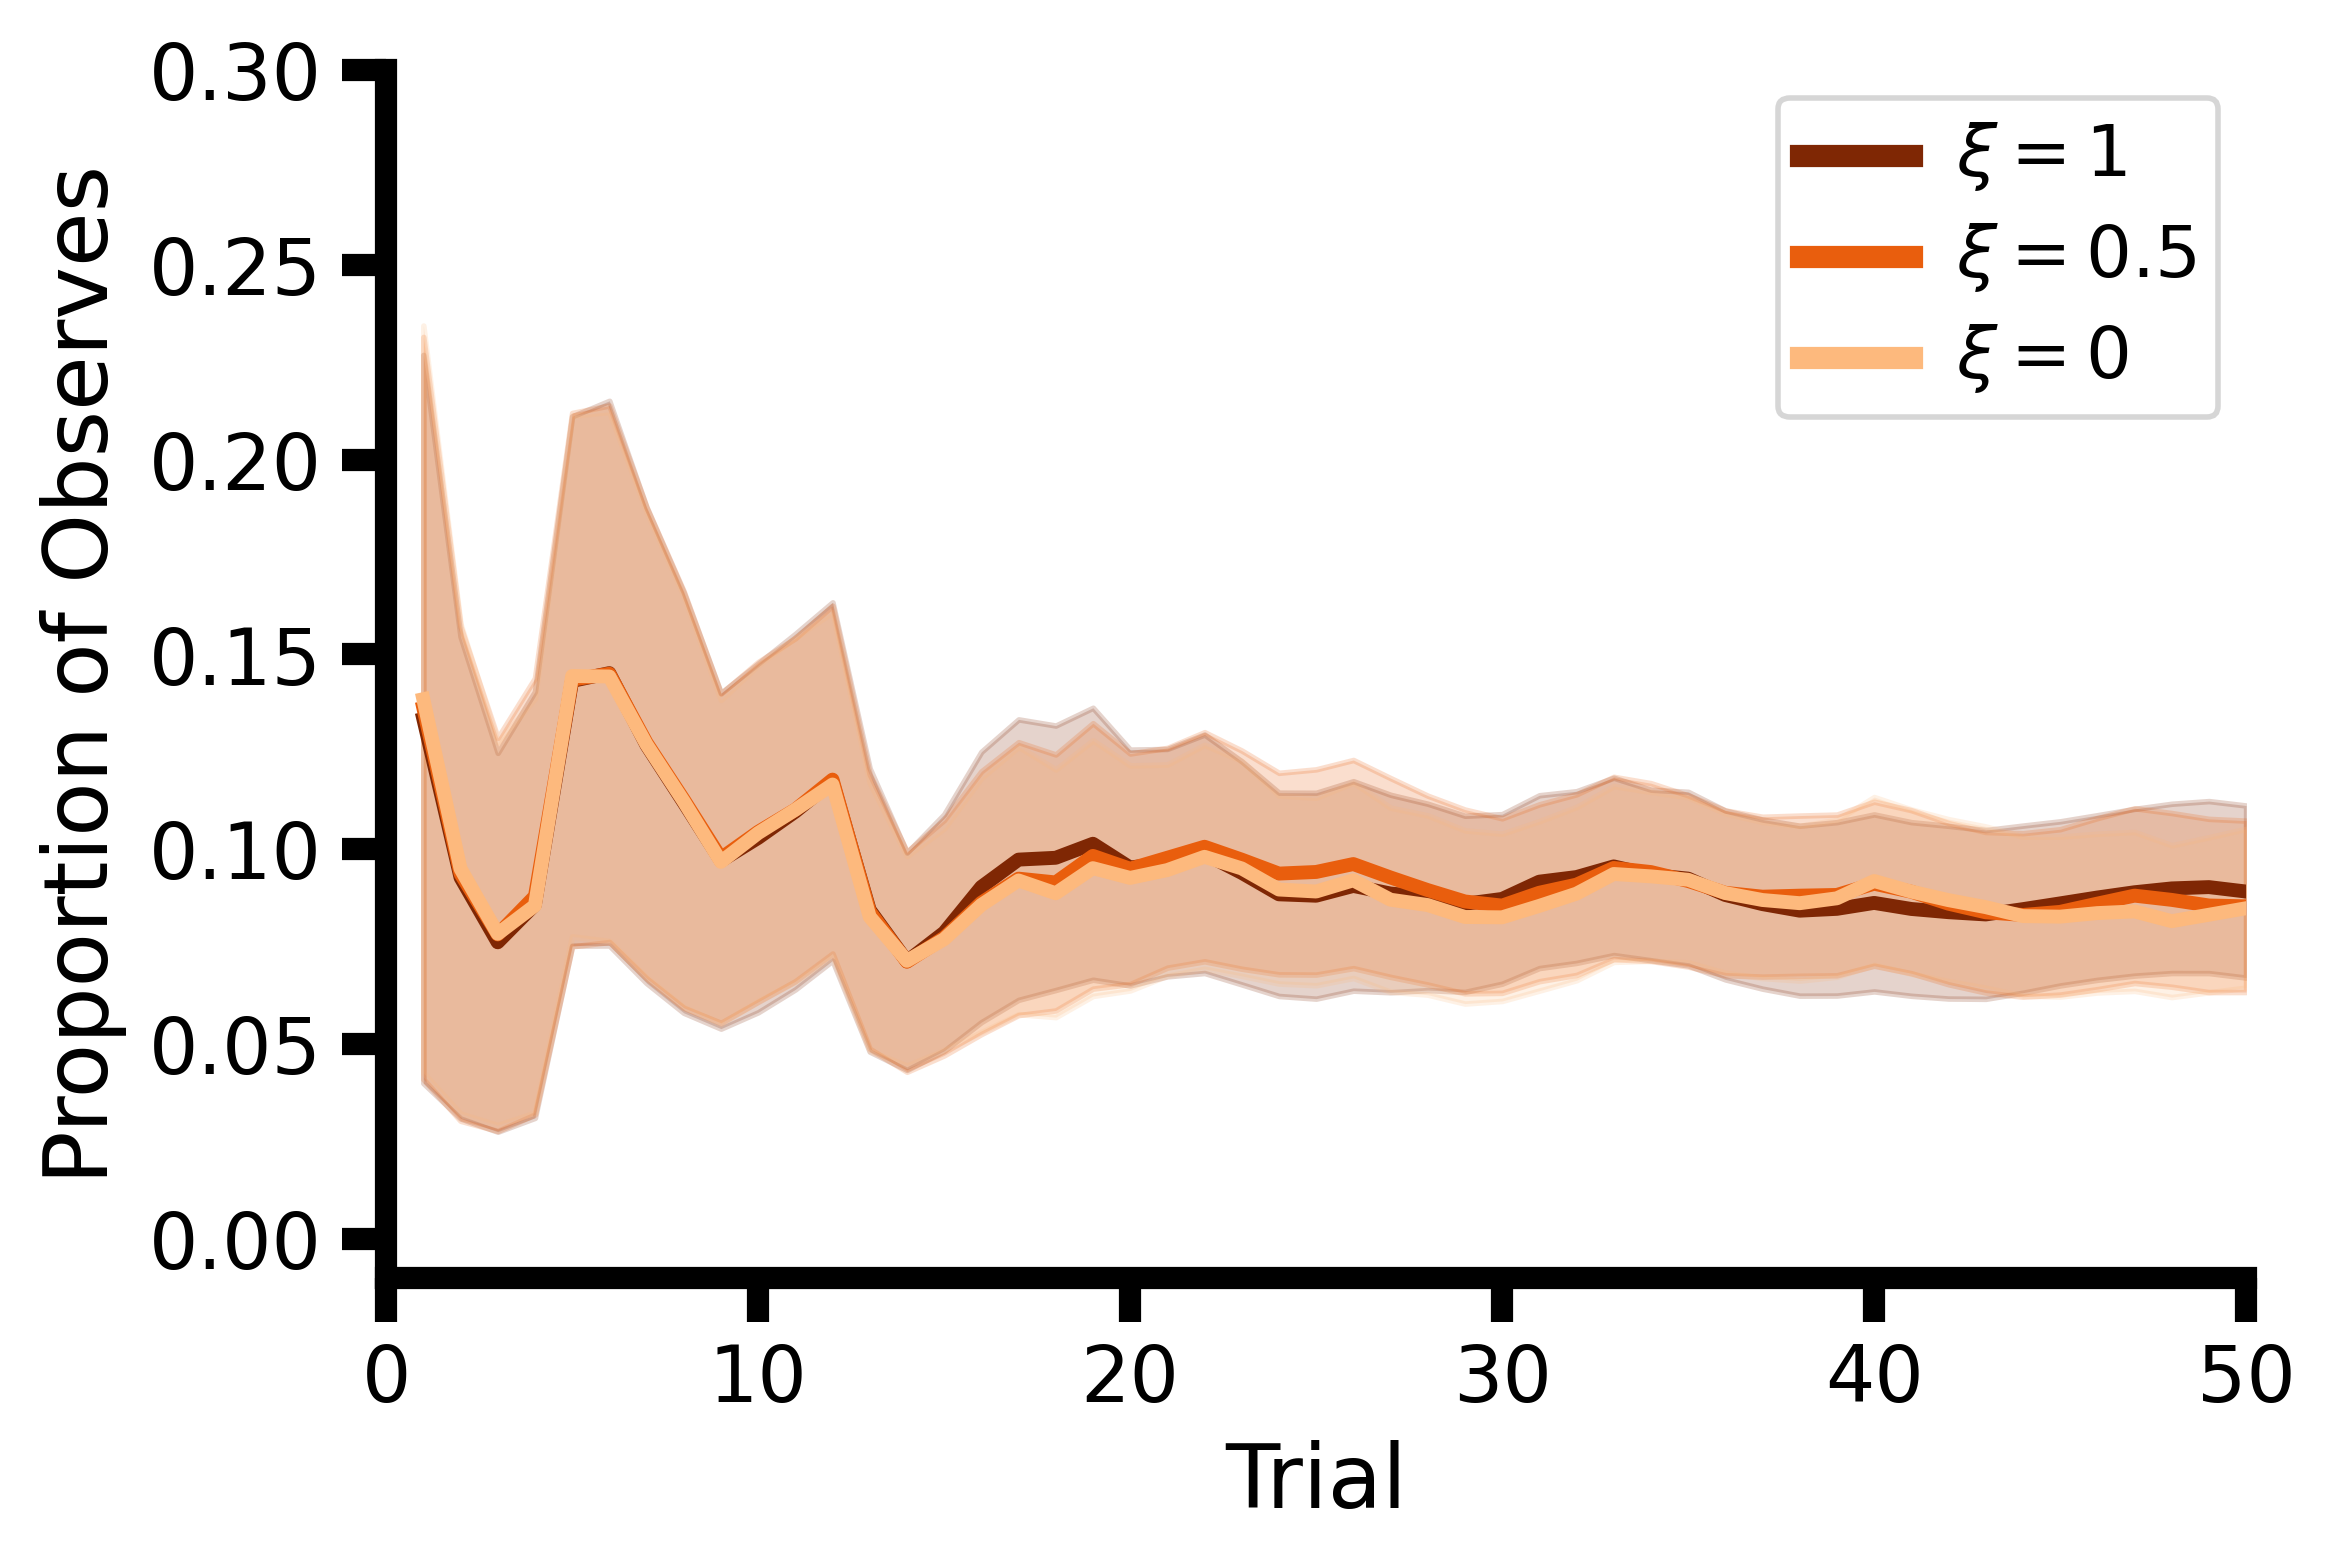

In [32]:
from test_analyses import frac_takes_lineplot

fig = frac_takes_lineplot(taus_to_plot, trajss_logits_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Proportion of Observes")

In [33]:
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_episode_noape.svg'))

## Panel C: Proportion Correct Bets
### General Options

In [34]:
ylim = (0, 1.0)
smoothing_window = 8

### Humans

In [35]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [36]:
transitions_train, transitions_test = sort_train_test(df['transitions_ep_rightwrong'], df['effs'], test_start, group = df['group'])
correct_takes = transitions_test
correct_takes = [correct_takes[0][:,3], correct_takes[1][:,2], correct_takes[0][:,0]] ## plotting highest efficacy first

## convert observations to np.nans
for correct_take in correct_takes:
    correct_take[correct_take == 0.5] = np.nan
    correct_take[correct_take == -1] = np.nan

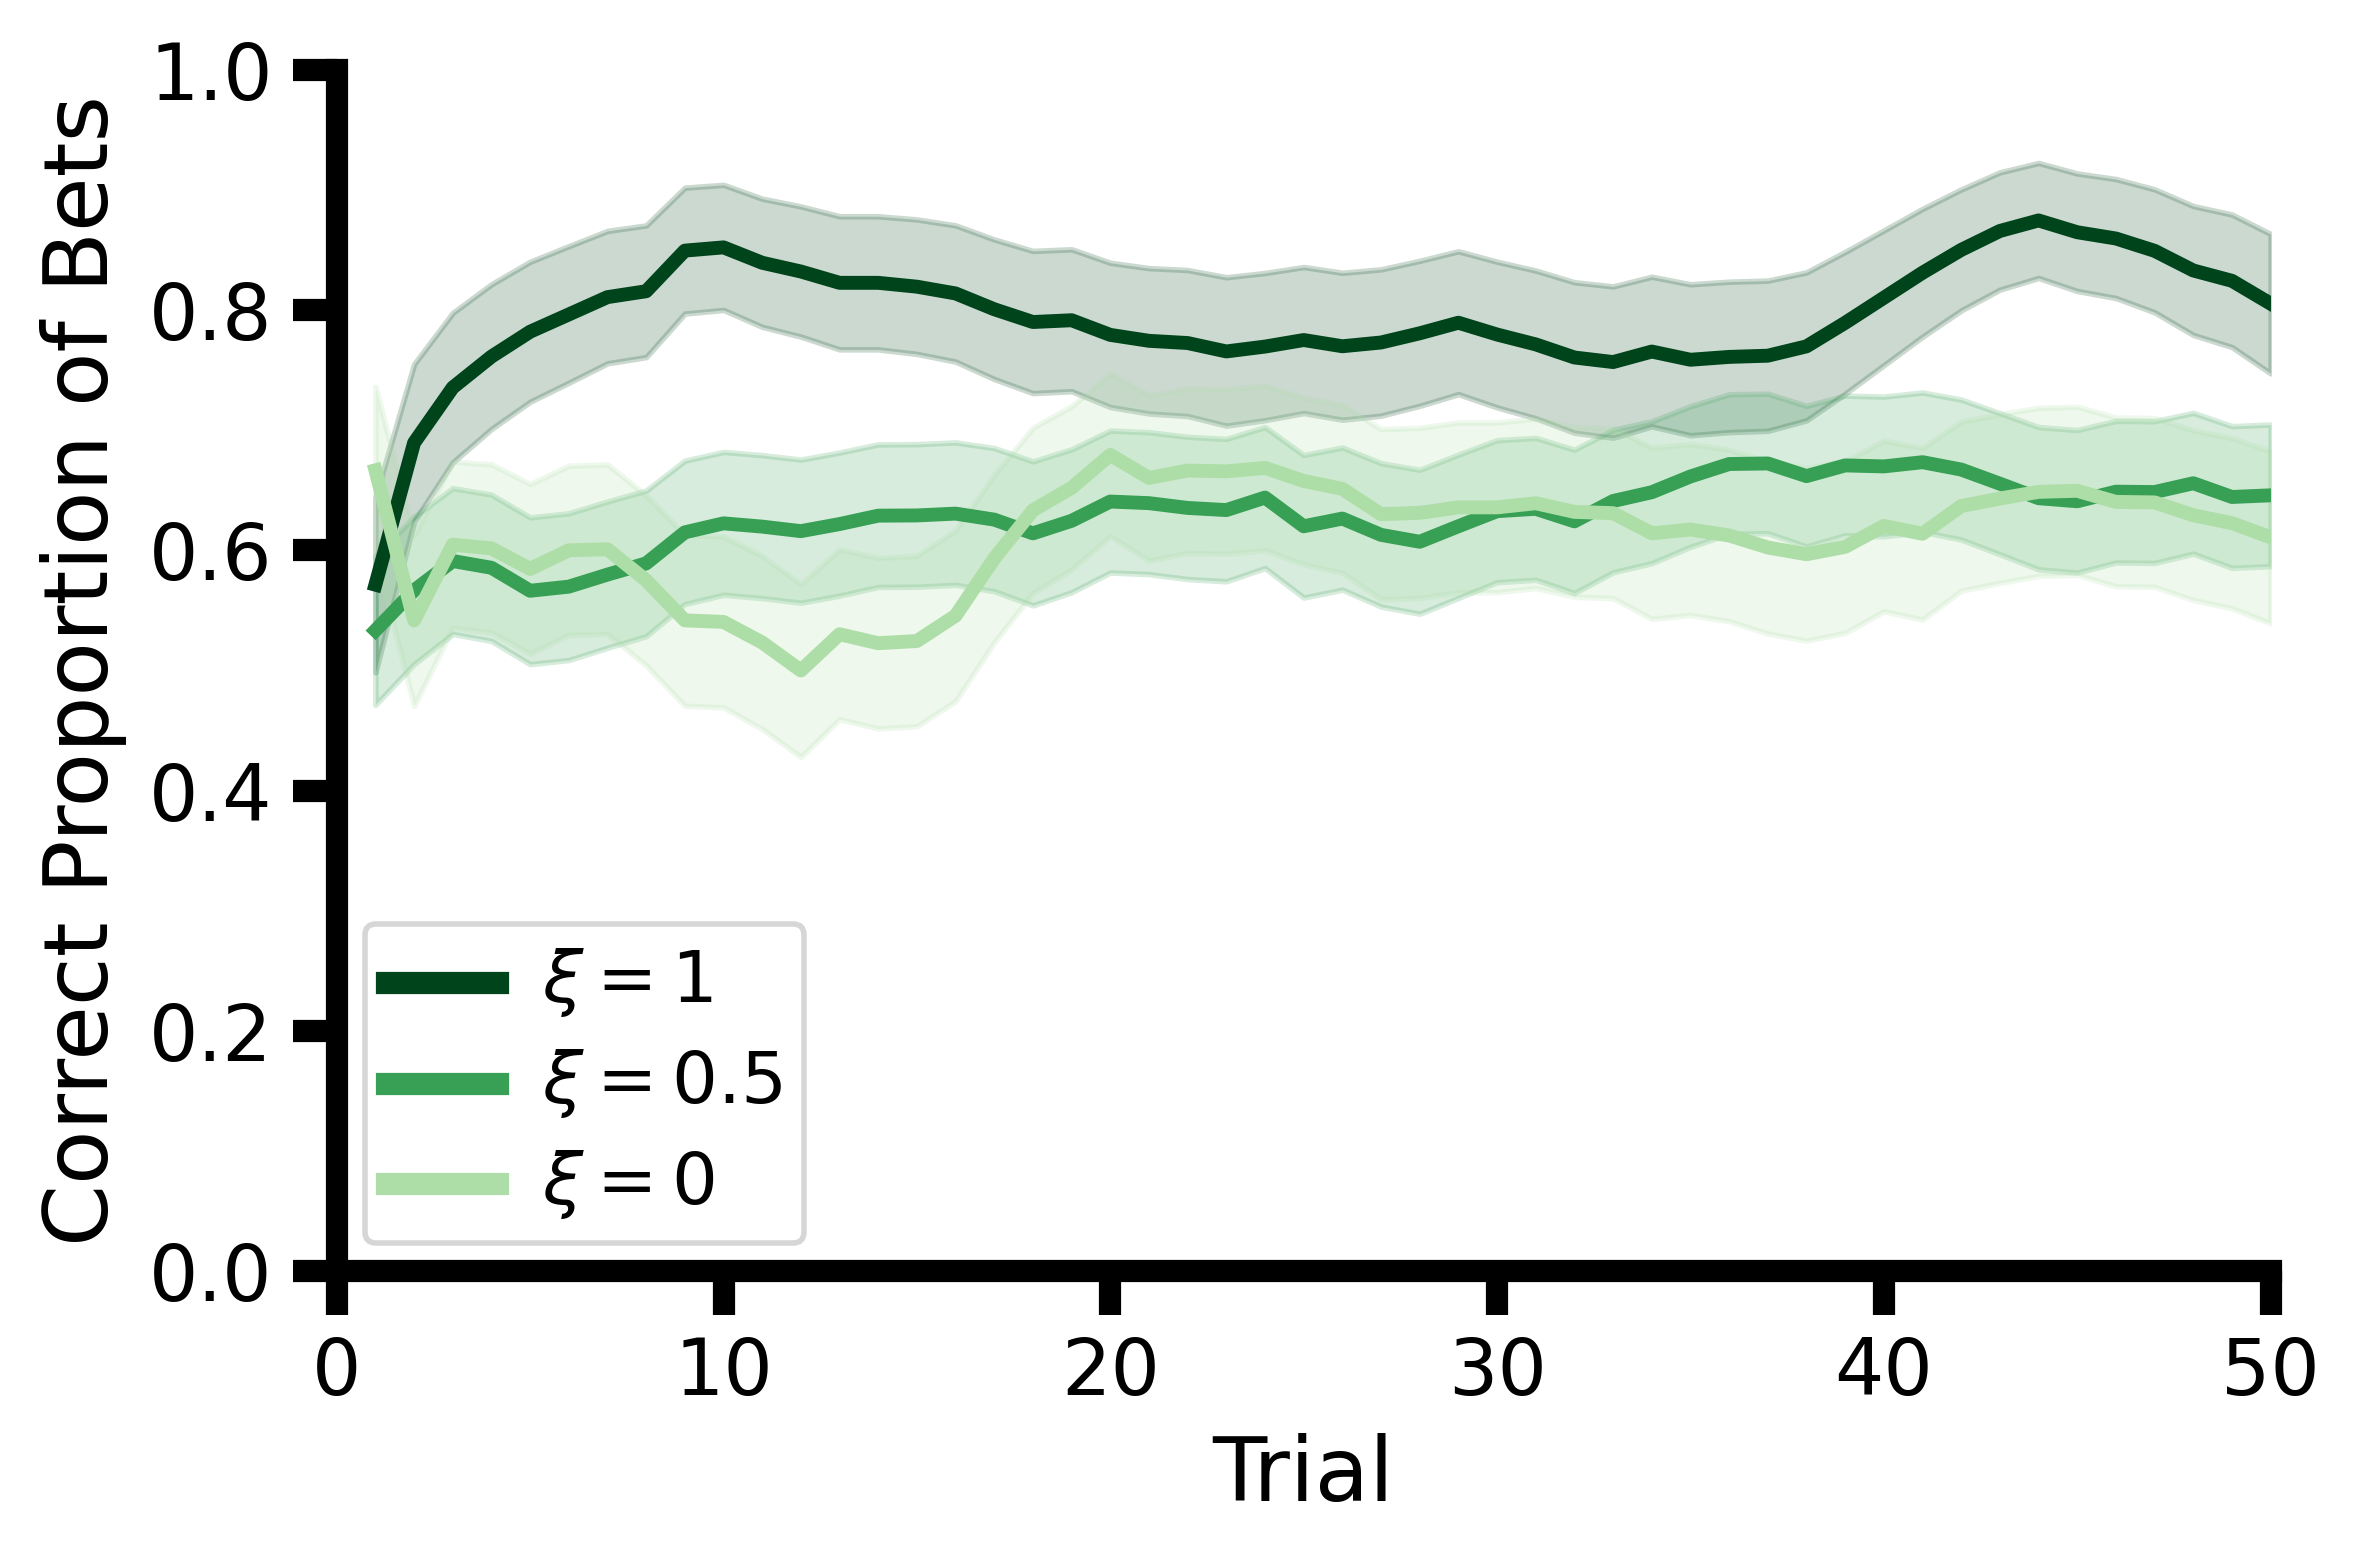

In [39]:
mean_probs = np.array([np.nanmean(correct_take, axis=0) for correct_take in correct_takes])
stderr_probs = np.array([np.nanstd(correct_take, axis=0)/np.sqrt(correct_take.shape[0]) for correct_take in correct_takes])

### smoothing based on rolling average
if smoothing_window > 1:
    mean_probs = pd.DataFrame(mean_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values
    stderr_probs = pd.DataFrame(stderr_probs).apply(lambda x: x.rolling(window=smoothing_window, min_periods=1).mean(), axis=1).values

## create figure
fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

steps = np.arange(1,mean_probs.shape[1]+1)

for i in range(len(mean_probs)):
    # ax.plot(steps, mean_peek_probs[i], label=1-taus[i], color='C%d' %i)
    ax.plot(steps, mean_probs[i], label=r"$\xi=$"+ str(effs_to_plot[i]), color=cmap_humans((len(mean_probs) - i)/len(mean_probs)))
    ax.fill_between(steps, mean_probs[i] - stderr_probs[i], mean_probs[i] + stderr_probs[i], color=cmap_humans((len(mean_probs) - i)/len(mean_probs)), alpha=0.2)

#ax.bar(range(len(policy)))

#ax.legend(title="Efficacy")
ax.legend()

ax.set_xlabel("Trial")
ax.set_ylabel("Correct Proportion of Bets")
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if ylim is not None:
    ax.set_ylim(ylim)

ax.set_xlim(0,50)

format_axis(ax)

plt.tight_layout()


In [40]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_humans.svg'))

### APE-trained Neural Network

In [41]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files

traj_base = os.path.join('data', 'eval', 'levc', )
traj_timestamp = '20240311133201'

cmap_apes = mpl.colormaps['Blues']
taus_to_plot = [0, 0.5, 1]

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_ape = np.array(trajss_logits_taus_ape)
trajss_logits_taus_ape = trajss_logits_taus_ape[:, ::4]

trajss_ps_taus_ape = np.array(trajss_ps_taus_ape)
trajss_ps_taus_ape = trajss_ps_taus_ape[:, ::4]

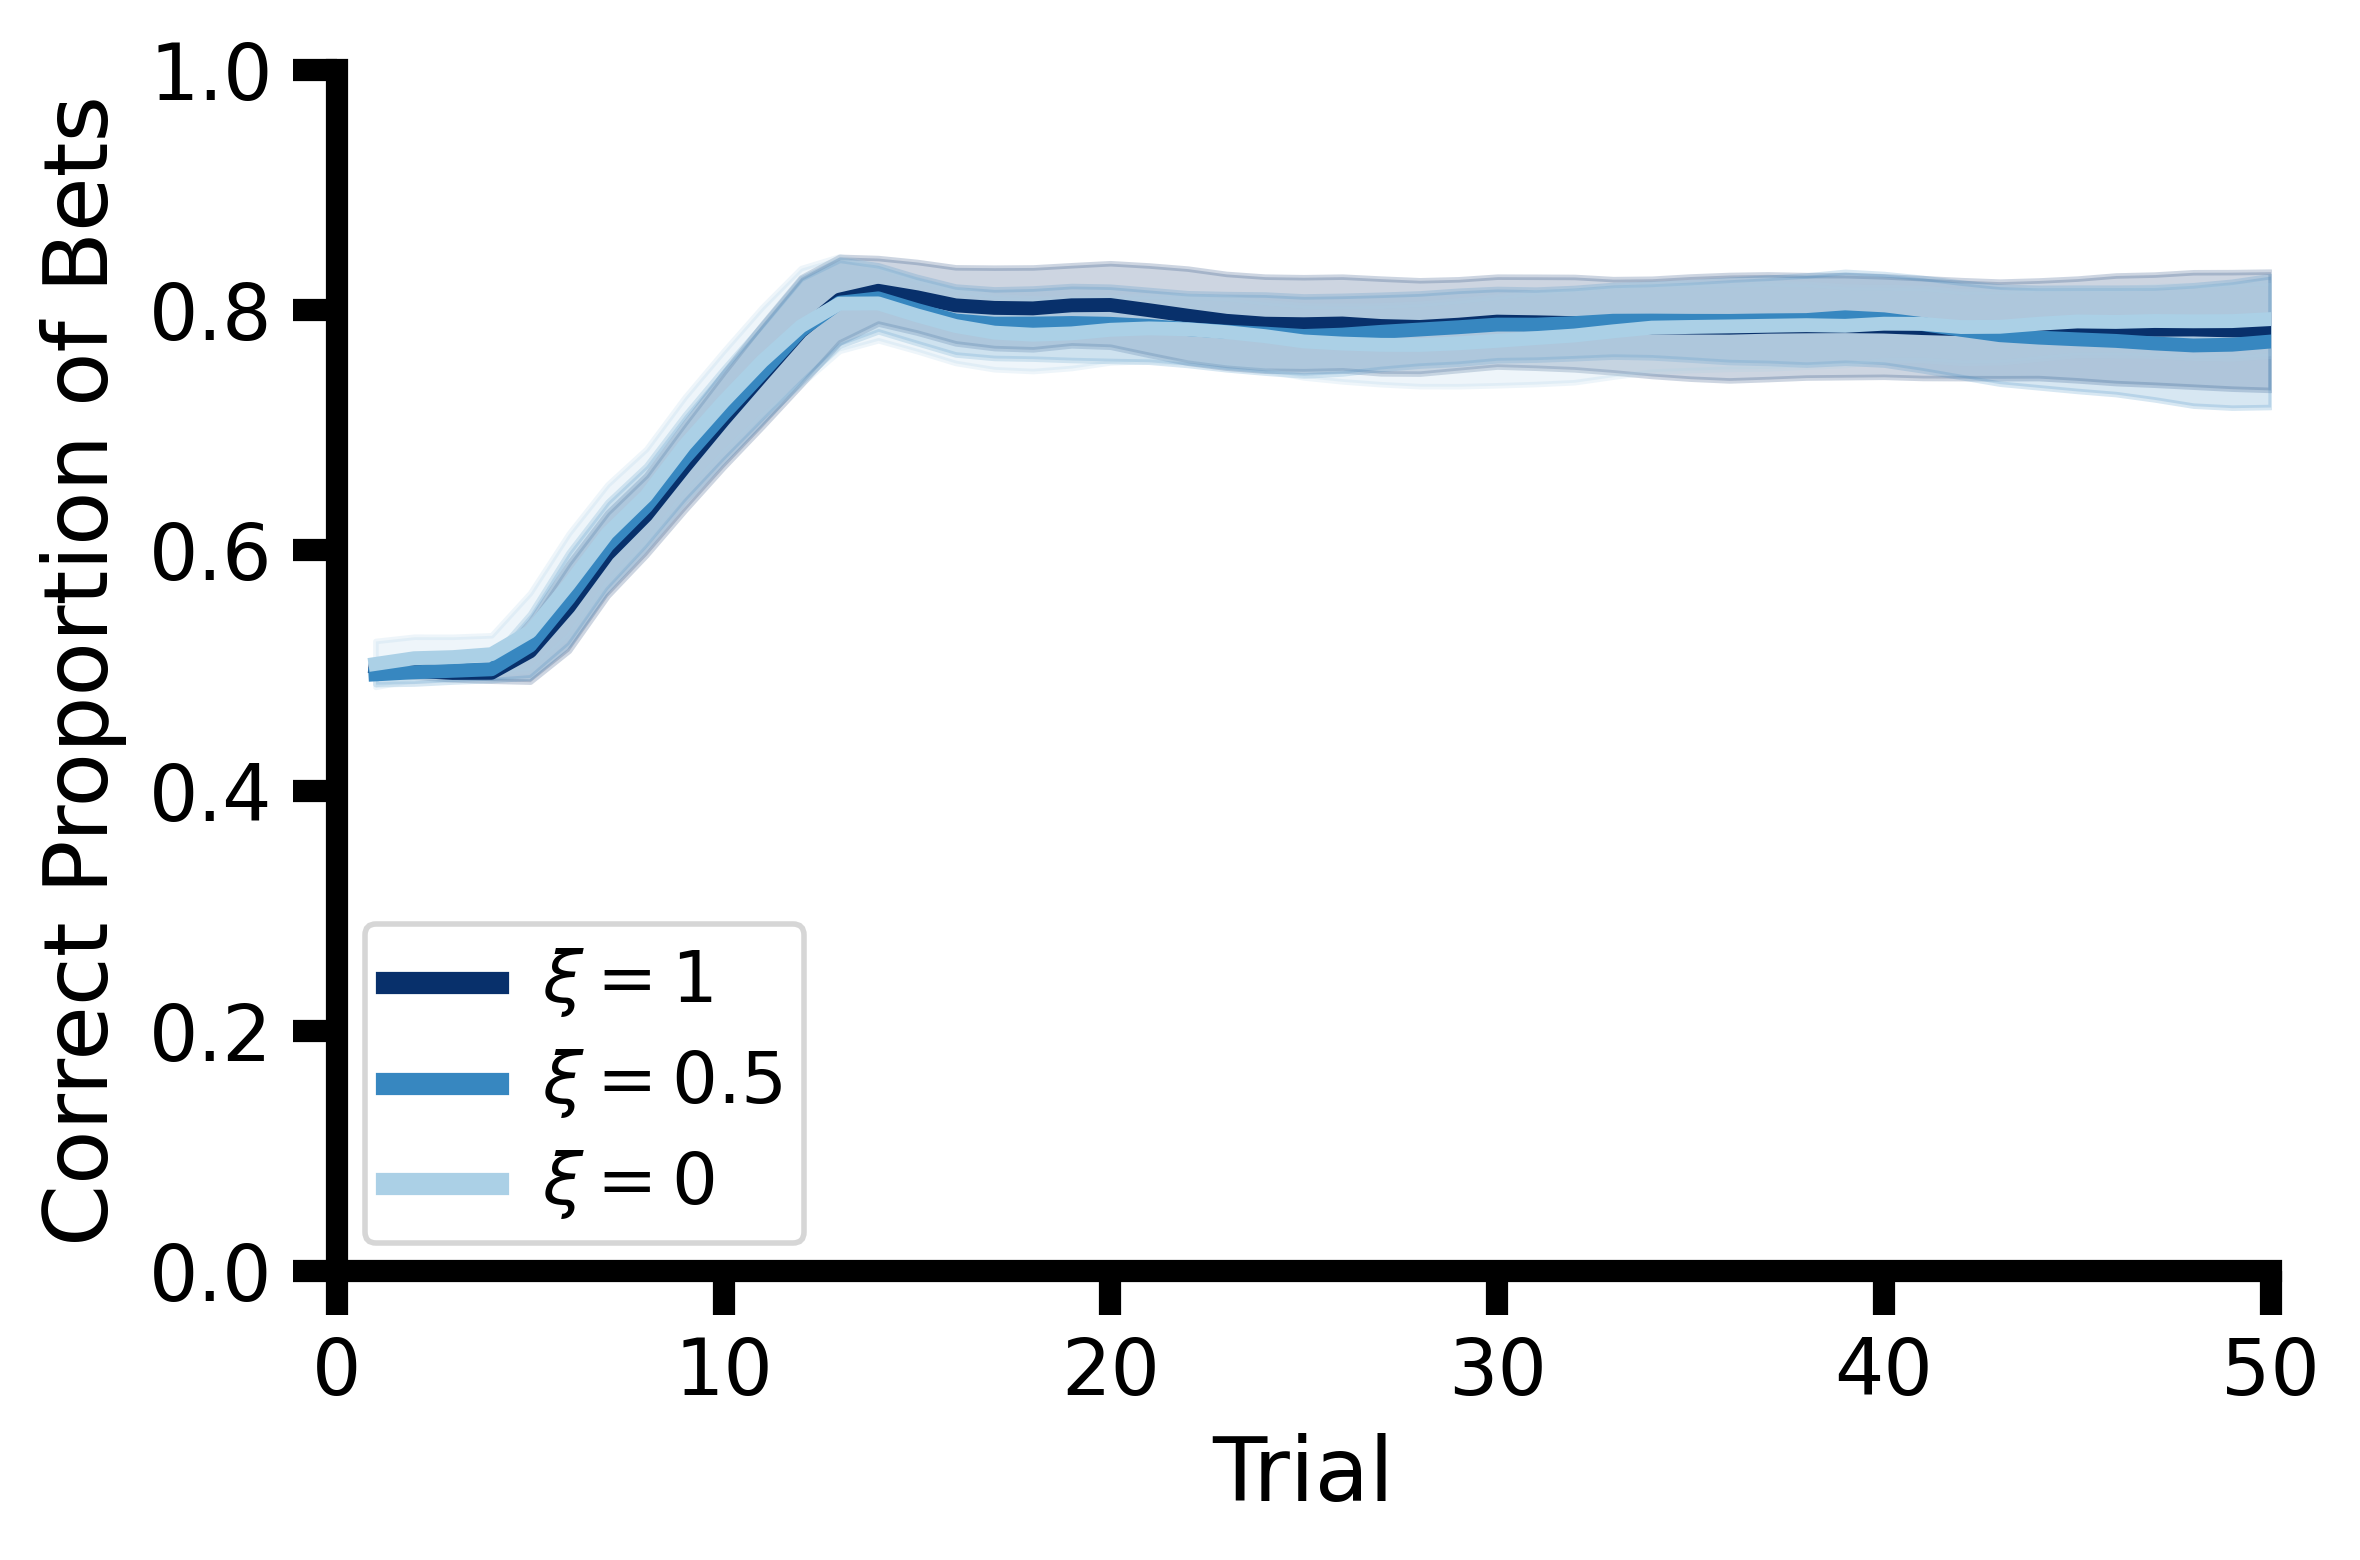

In [42]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_ape, trajss_ps_taus_ape, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_apes, ylabel="Correct Proportion of Bets", includes_sleep=True)

In [43]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_apes.svg'))

### No APE Neural Network

In [44]:
from settings_ana import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
taus_to_plot = [0, 0.5, 1]

rewss_taus_control, counterss_peeks_taus_control, _, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base)

## select only the taus to plot
trajss_logits_taus_control = np.array(trajss_logits_taus_control)
trajss_logits_taus_control = trajss_logits_taus_control[:, ::4]

trajss_ps_taus_control = np.array(trajss_ps_taus_control)
trajss_ps_taus_control = trajss_ps_taus_control[:, ::4]

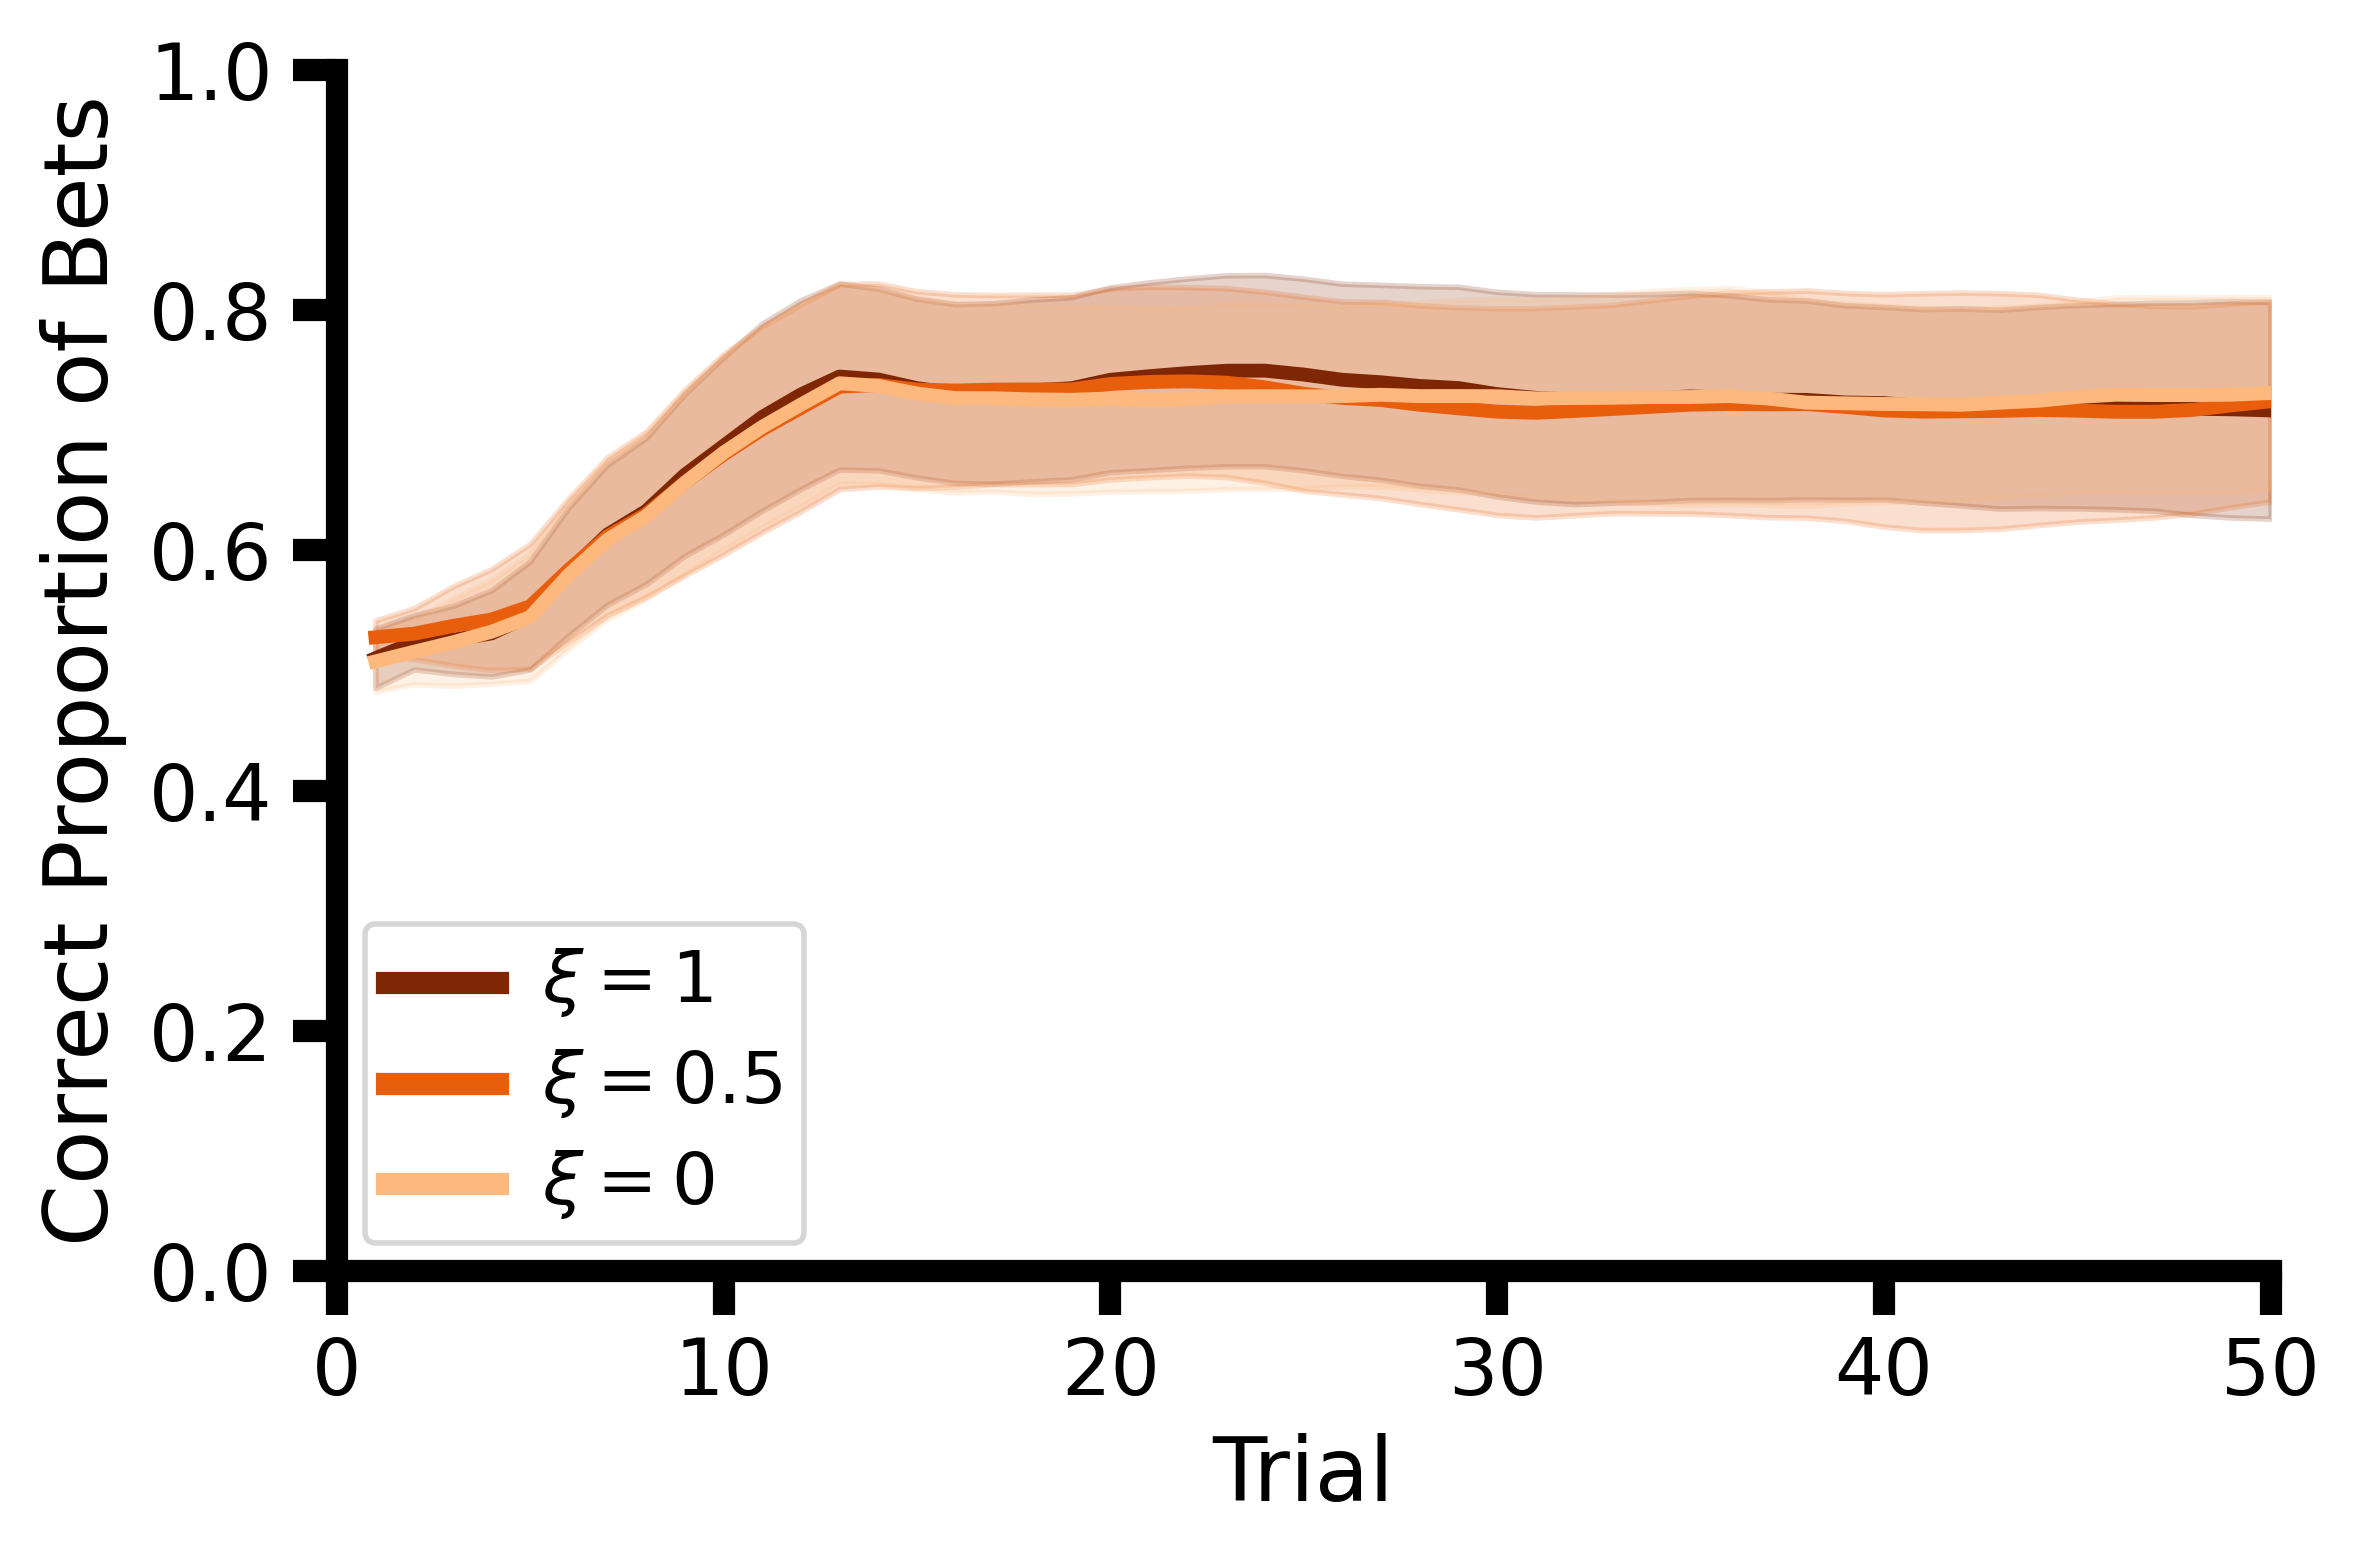

In [45]:
from test_analyses import frac_correct_takes_lineplot

fig = frac_correct_takes_lineplot(taus_to_plot, trajss_logits_taus_control, trajss_ps_taus_control, ylim=ylim, smoothing_window=smoothing_window, cmap = cmap_control, ylabel="Correct Proportion of Bets", includes_sleep=True)

In [46]:
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noapes.png'))
fig.savefig(os.path.join(analysis_folder, 'correct_bets_episode_noapes.svg'))

## Panel D: Across-Episode Sleeps
### General Options

In [47]:
ylim = (-1.25,25.5)

### Humans

In [48]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [49]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['n_sleeps'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['n_sleeps'], df[df['group']]['effs'], test_start[1])

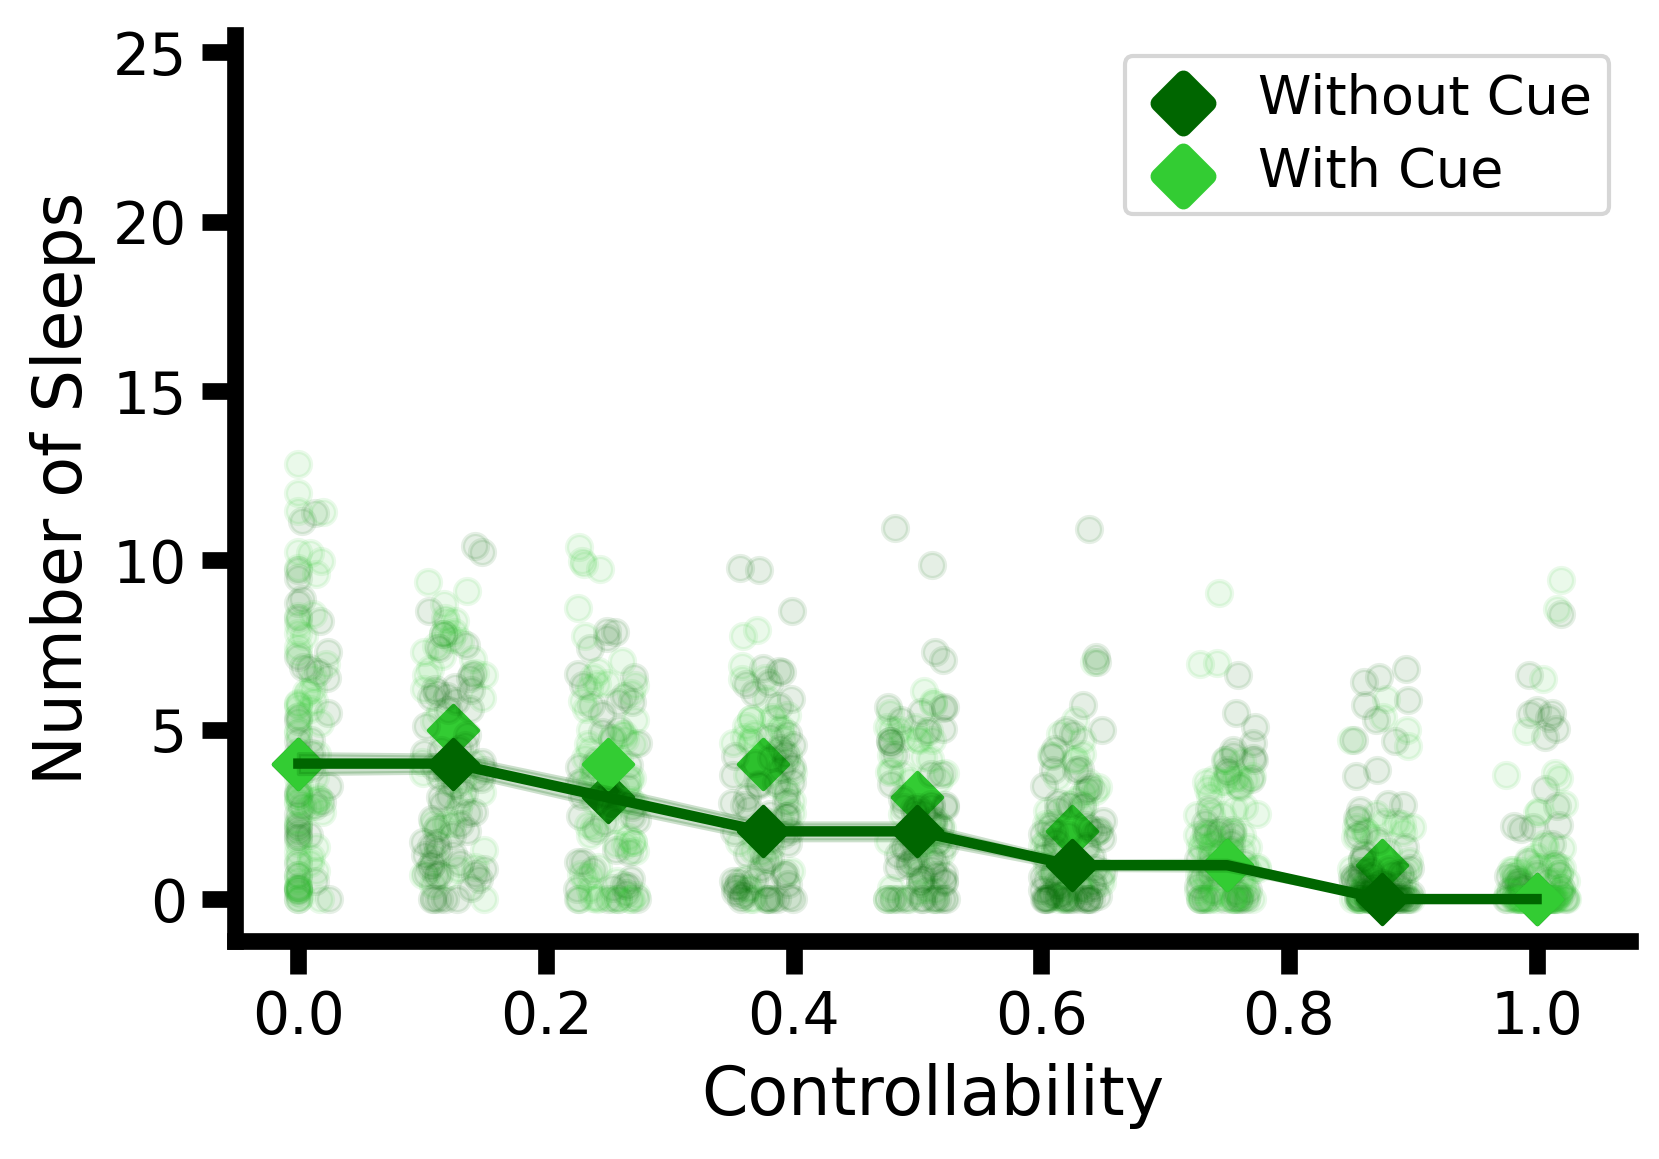

In [50]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Number of Sleeps', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim)

In [47]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_humans.svg'))

### APE-trained Neural Networks

In [48]:
from settings_ana import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)


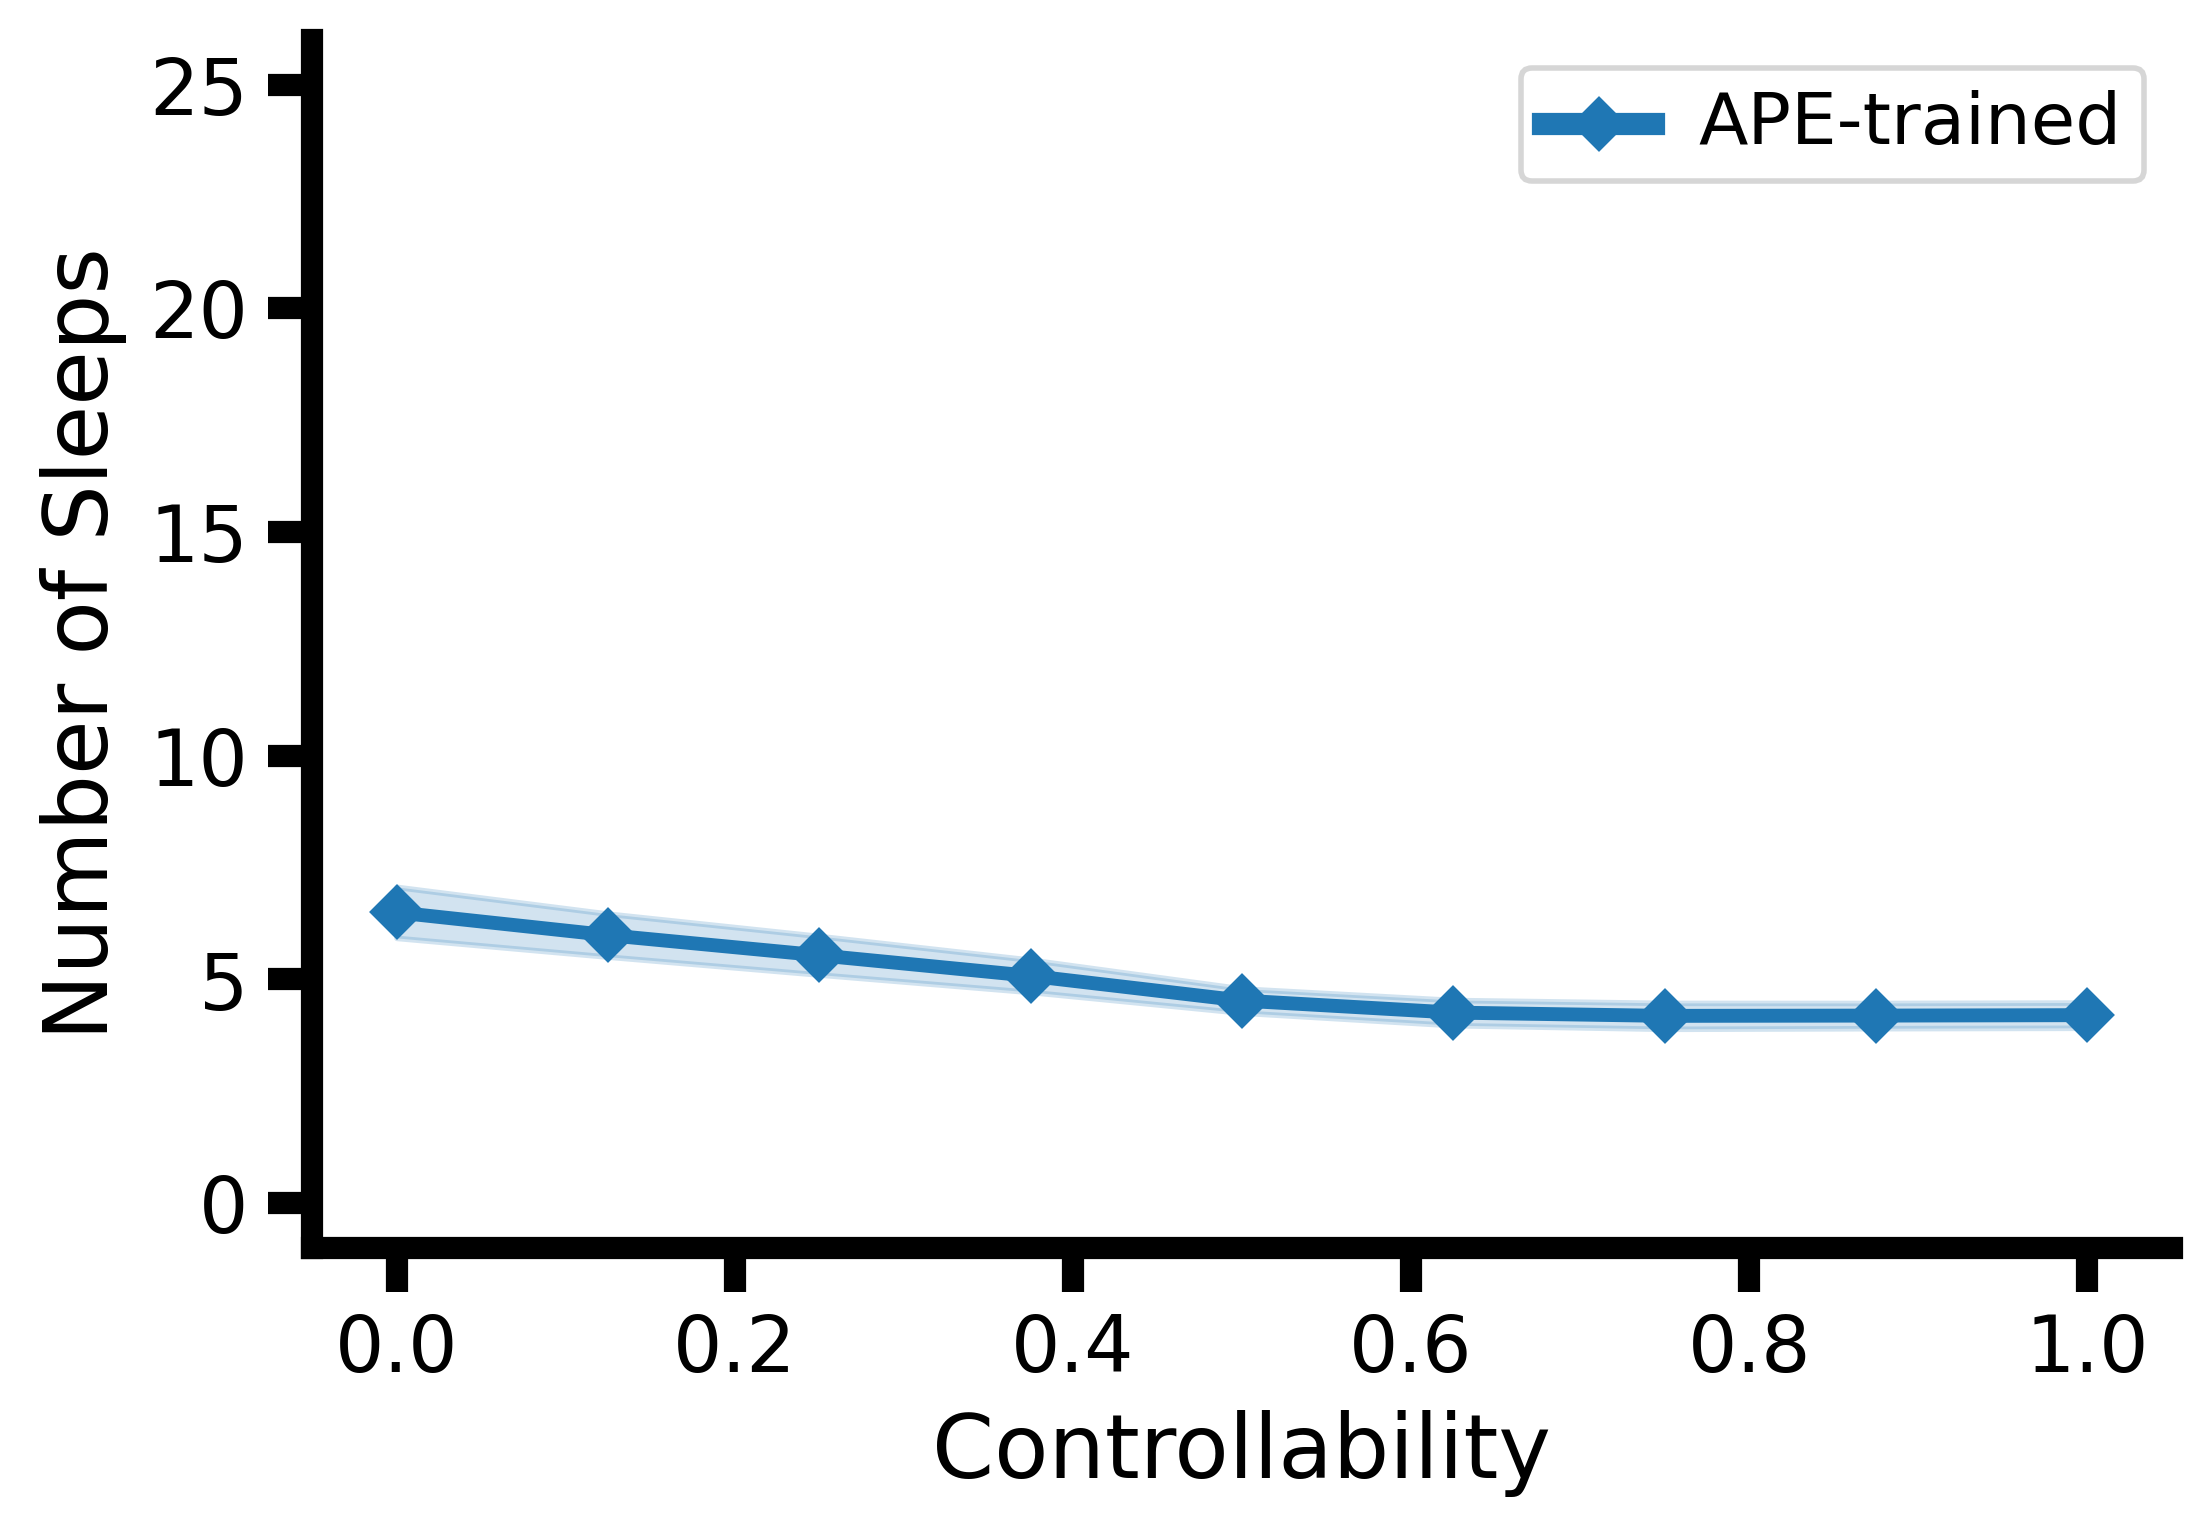

In [49]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_sleeps_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Sleeps', label_exp='APE-trained', label_control='no APE', ylim=(-1, 26), marker='D')

In [50]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_ape.svg'))

### No APE Networks

In [51]:
from settings_ana import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

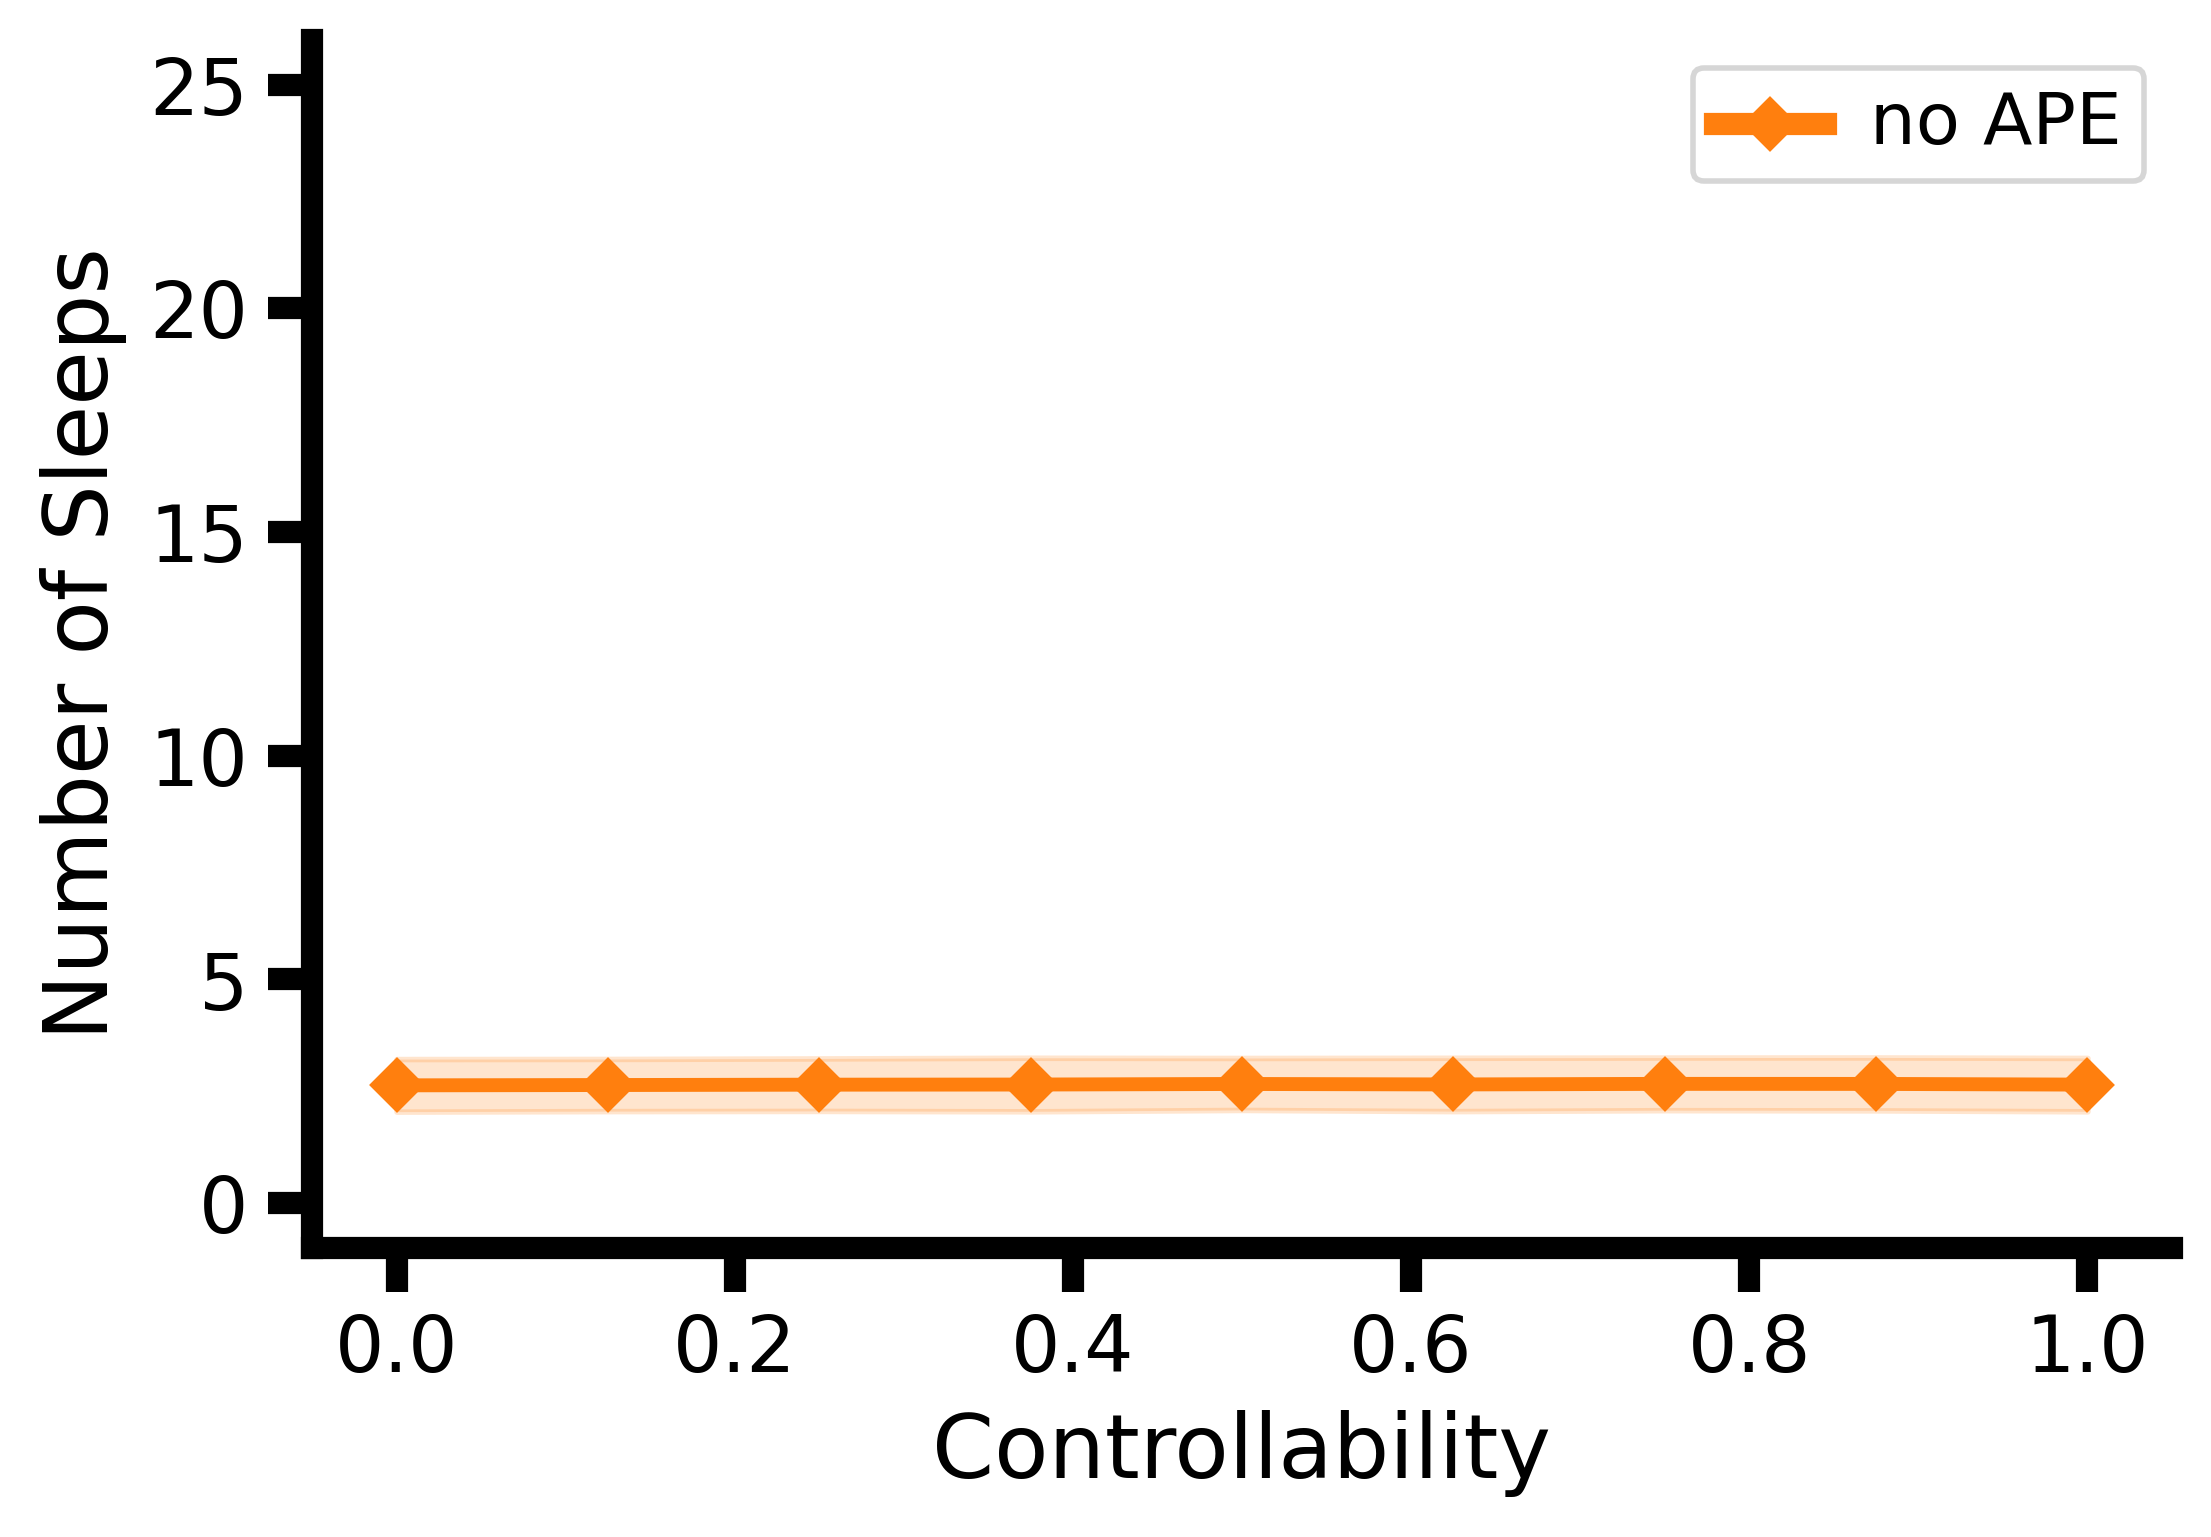

In [52]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_sleeps_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Sleeps', label_exp='APE-trained', label_control='no APE', ylim=(-1, 26), marker='D')

In [53]:
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'sleeps_across_noape.svg'))

## Panel E: Across-Episode Observations
### General Options

In [54]:
ylim = (-1.25,25.5)

### Humans

In [55]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [56]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['n_observes'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['n_observes'], df[df['group']]['effs'], test_start[1])

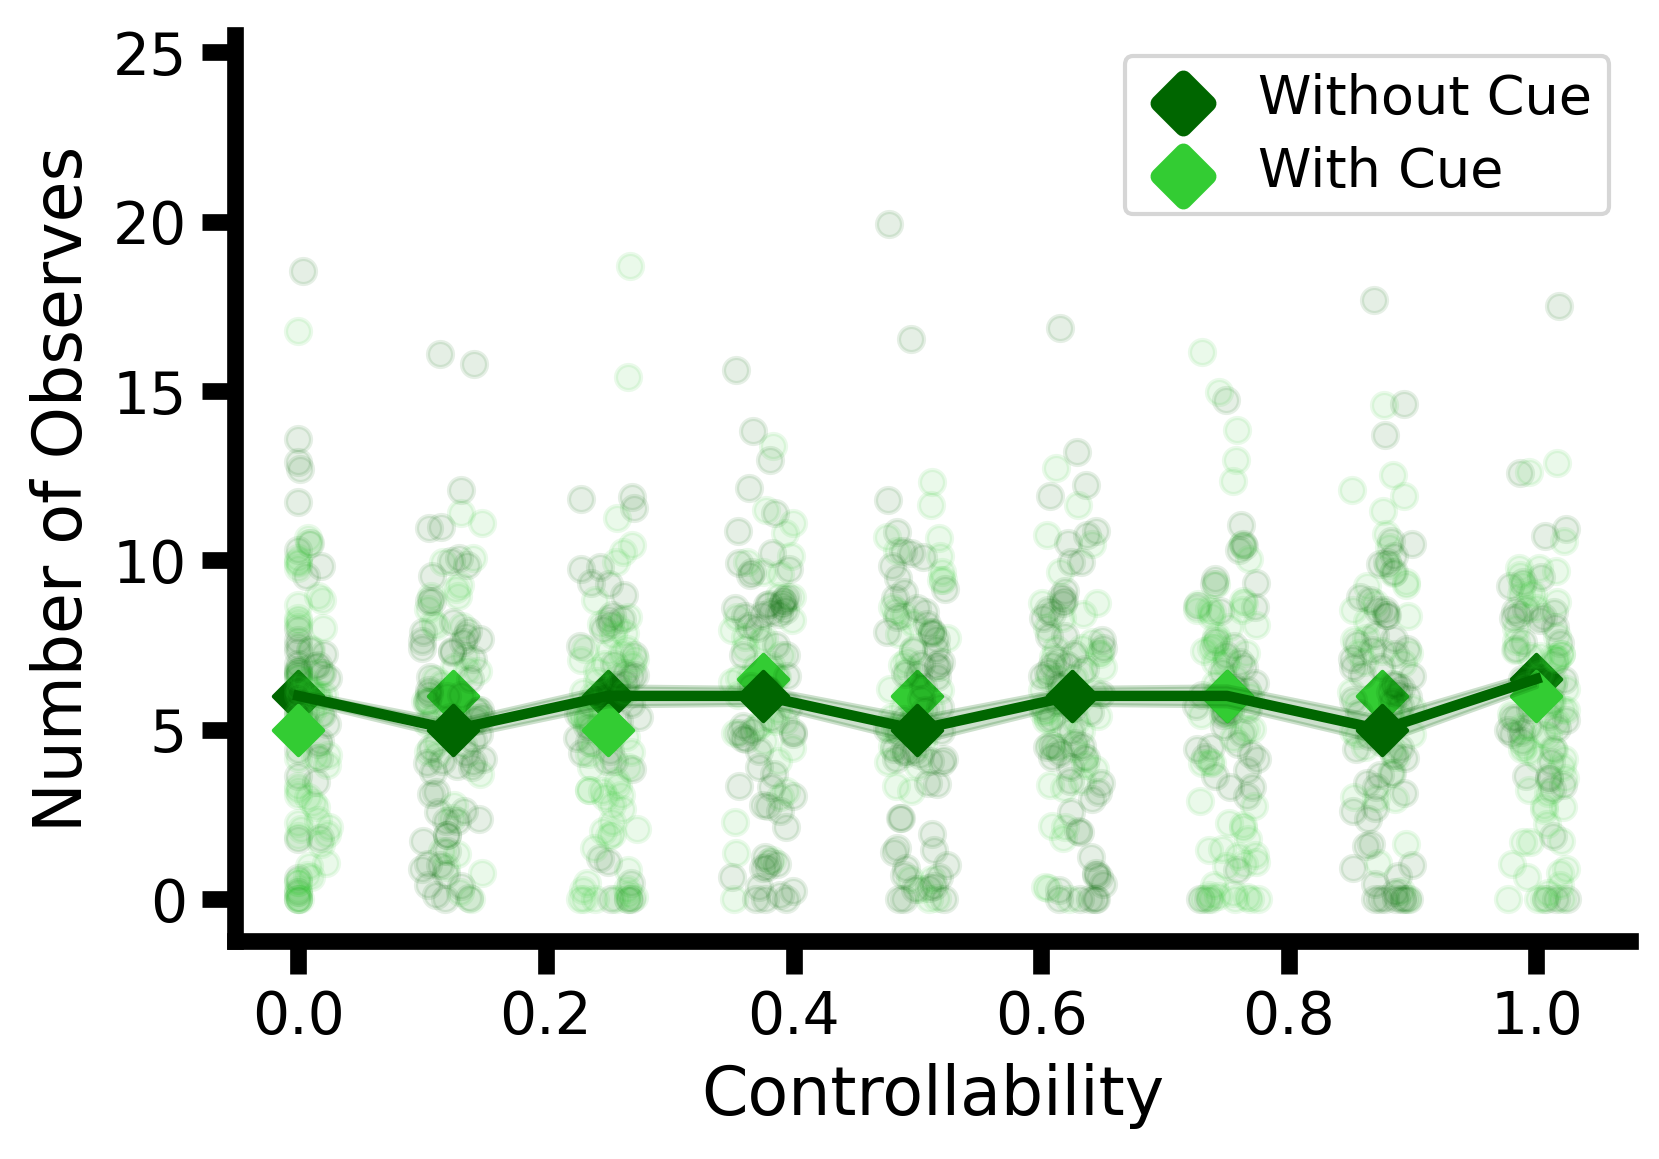

In [57]:
from human_plot_traj_analyses import plot_line_scatter_group
    
fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Number of Observes', xjitter=0.025, yjitter=1, median_over_mean=True, ylim=ylim)

In [58]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_humans.svg'))

### APE-trained Neural Networks

In [59]:
from settings_ana import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_ana import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)

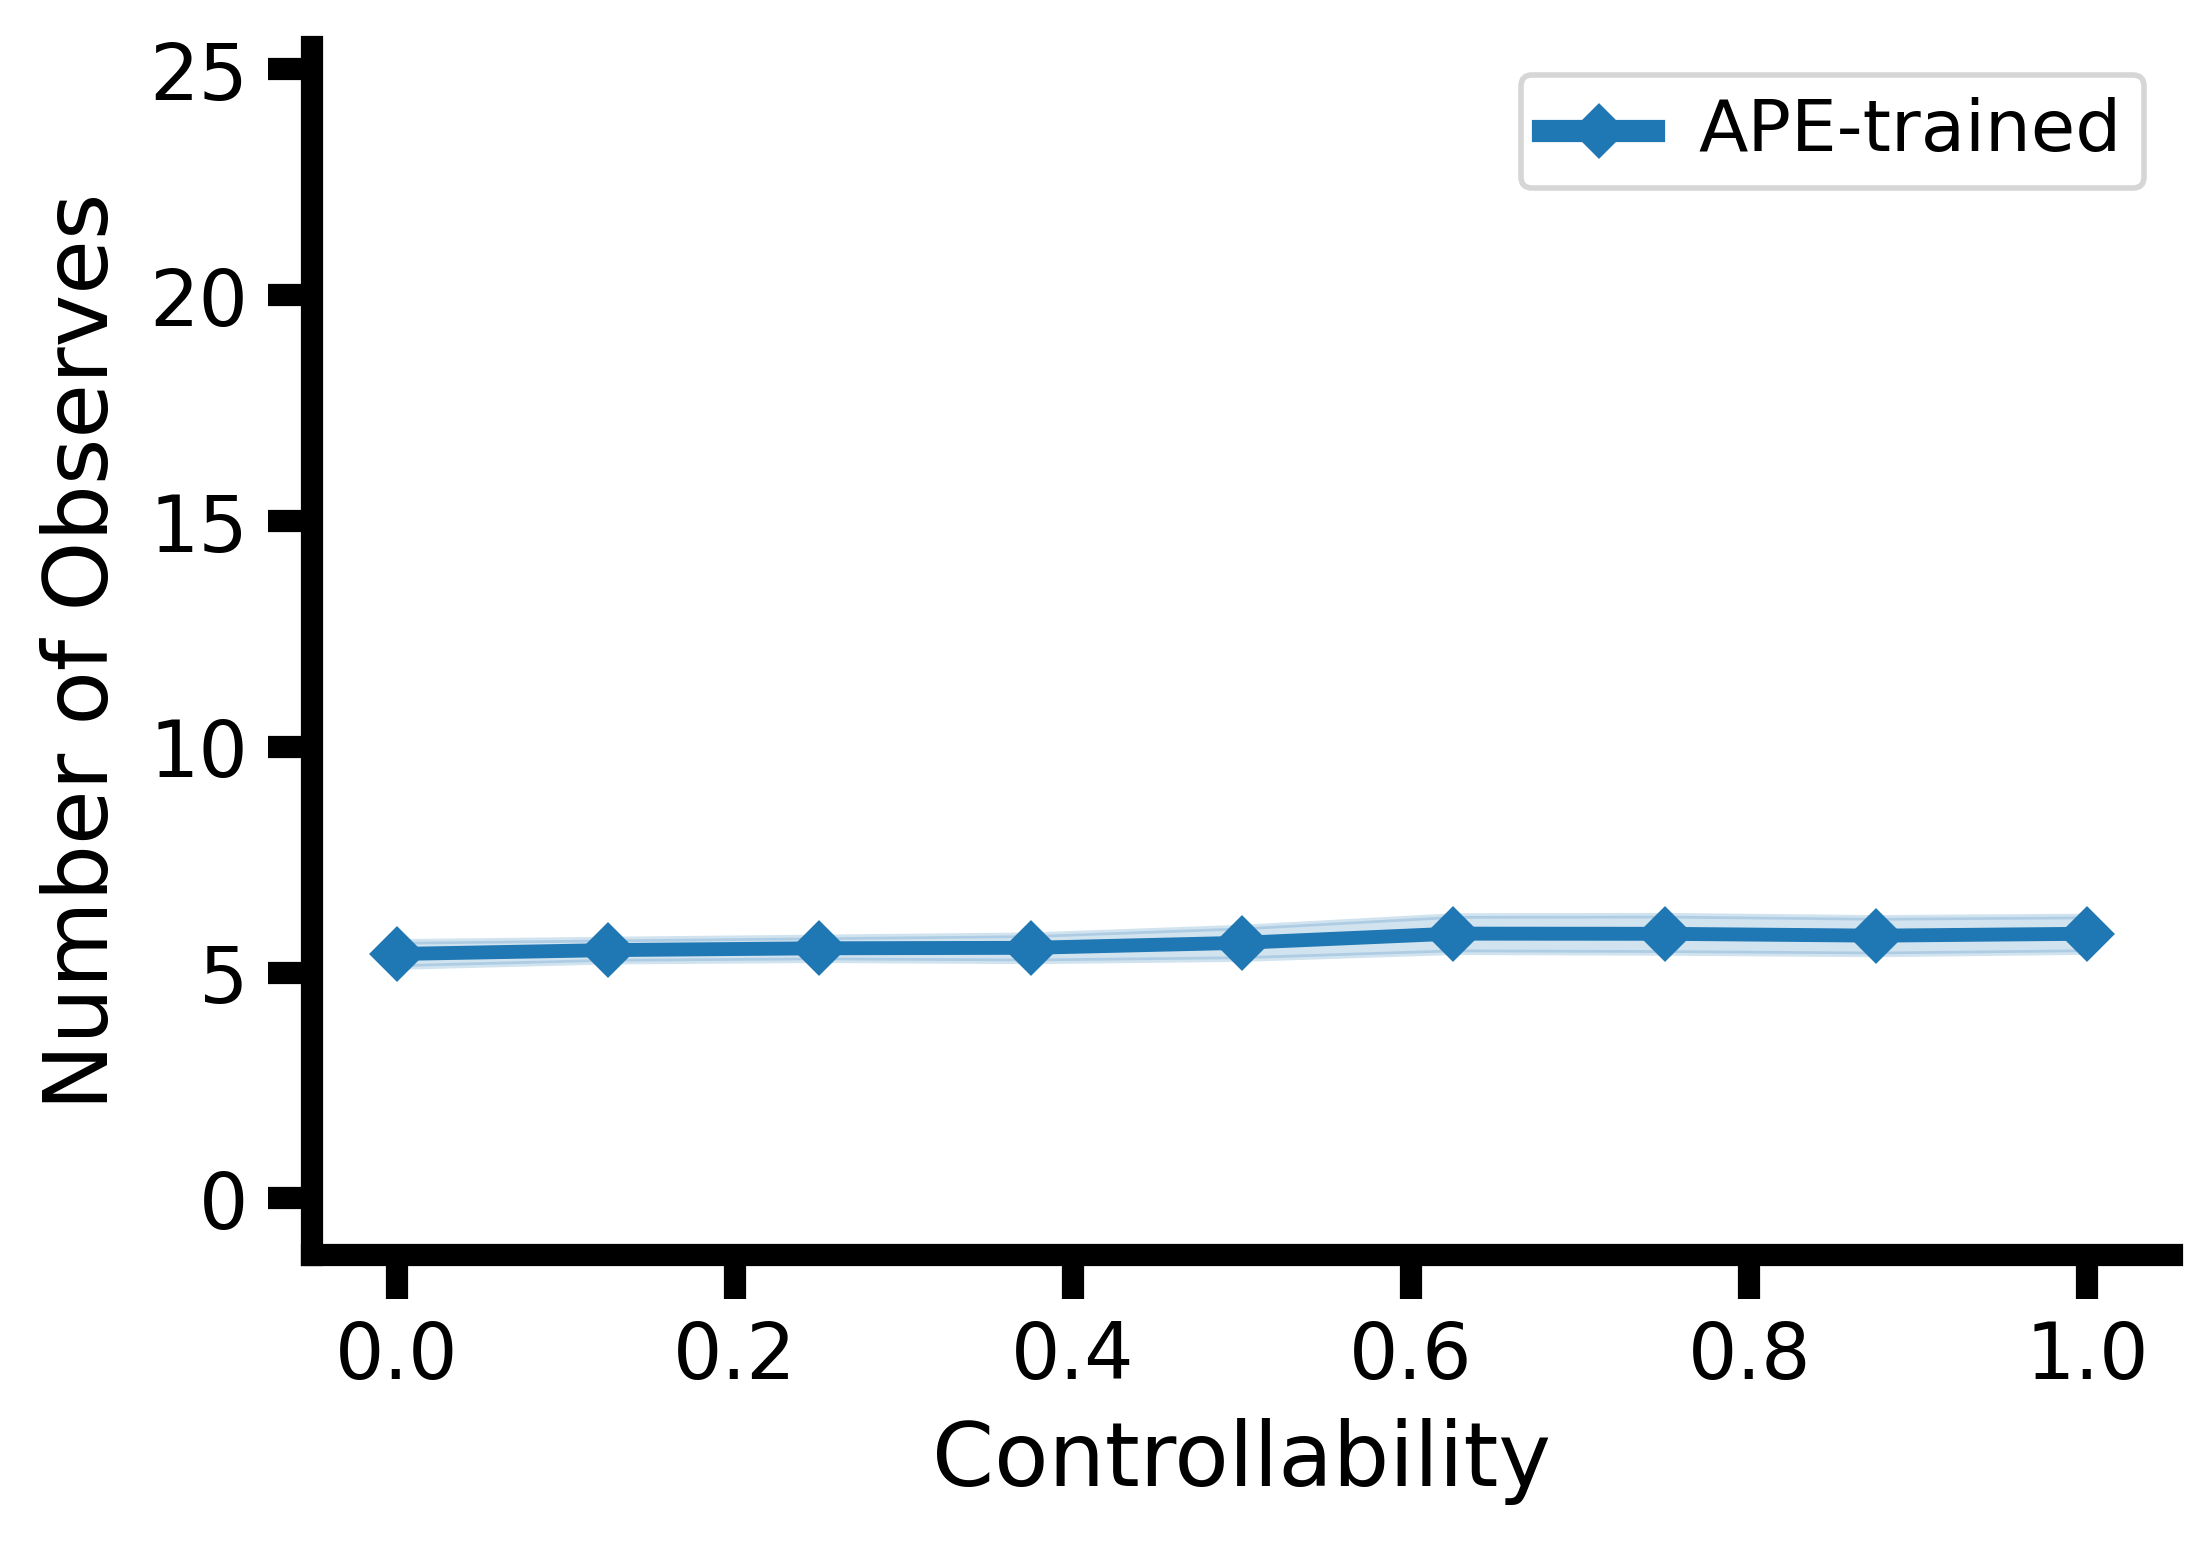

In [60]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(test_taus, list(reversed(counterss_peeks_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [61]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_ape.svg'))

### No APE Networks

In [62]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

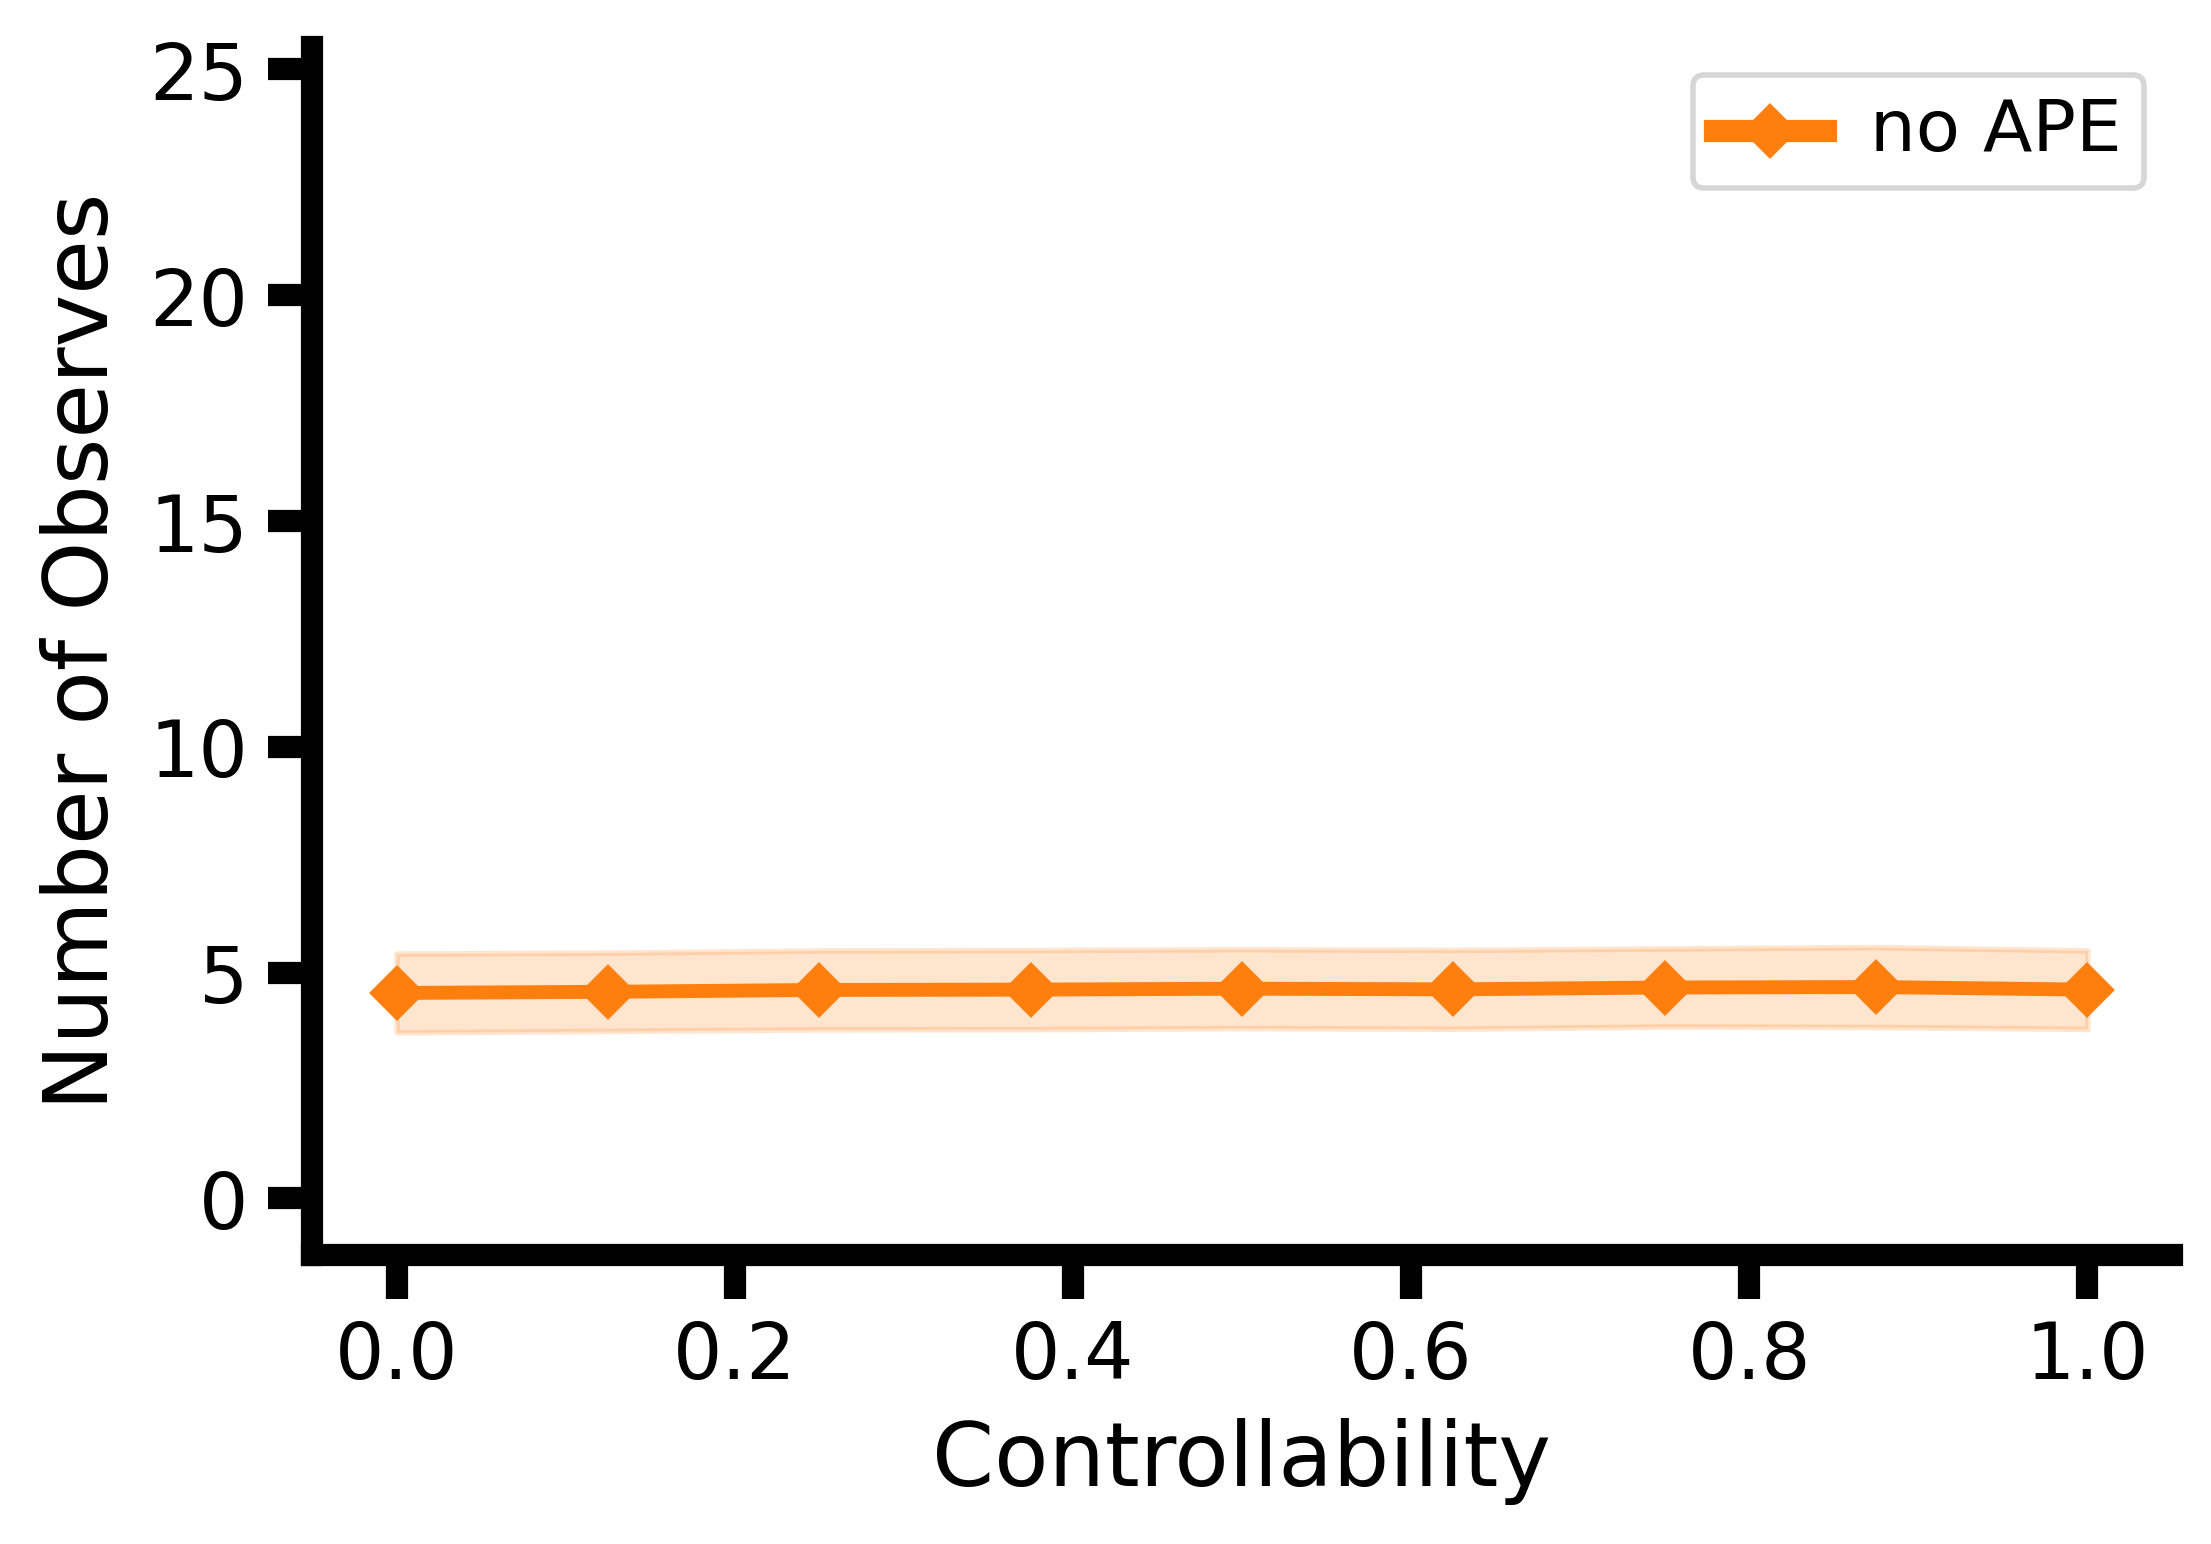

In [63]:
from test_analyses import plot_comparison_curves_several_runs

fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(counterss_peeks_taus_control)), axis_xlabel='Controllability', axis_ylabel='Number of Observes', label_exp='APE-trained', label_control='no APE', ylim=ylim, marker='D')

In [64]:
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'observes_across_noape.svg'))

## Panel F: Rewards
### General Options

In [13]:
ylim= (-1, 49)

### Humans

In [14]:
from human_utils_project import get_clean_data, sort_train_test

day = 'day3'
exp_date = '24-01-22-29'

day1_test_mask_cutoff = {
    "groupA": {"lower": 10, "upper": 90},
    "groupB": {"lower": 8, "upper": 72}
}

group = None

df, effs_train, effs_test, test_start = get_clean_data(day = int(day[-1]), exp_date = exp_date, day1_test_mask_cutoff=day1_test_mask_cutoff, group=group, file_base=human_data_file_base)

cmap_humans = mpl.colormaps['Greens']

In [15]:
n_trainA, n_testA = sort_train_test(df[~df['group']]['rewards_tallies'], df[~df['group']]['effs'], test_start[0])
n_trainB, n_testB = sort_train_test(df[df['group']]['rewards_tallies'], df[df['group']]['effs'], test_start[1])

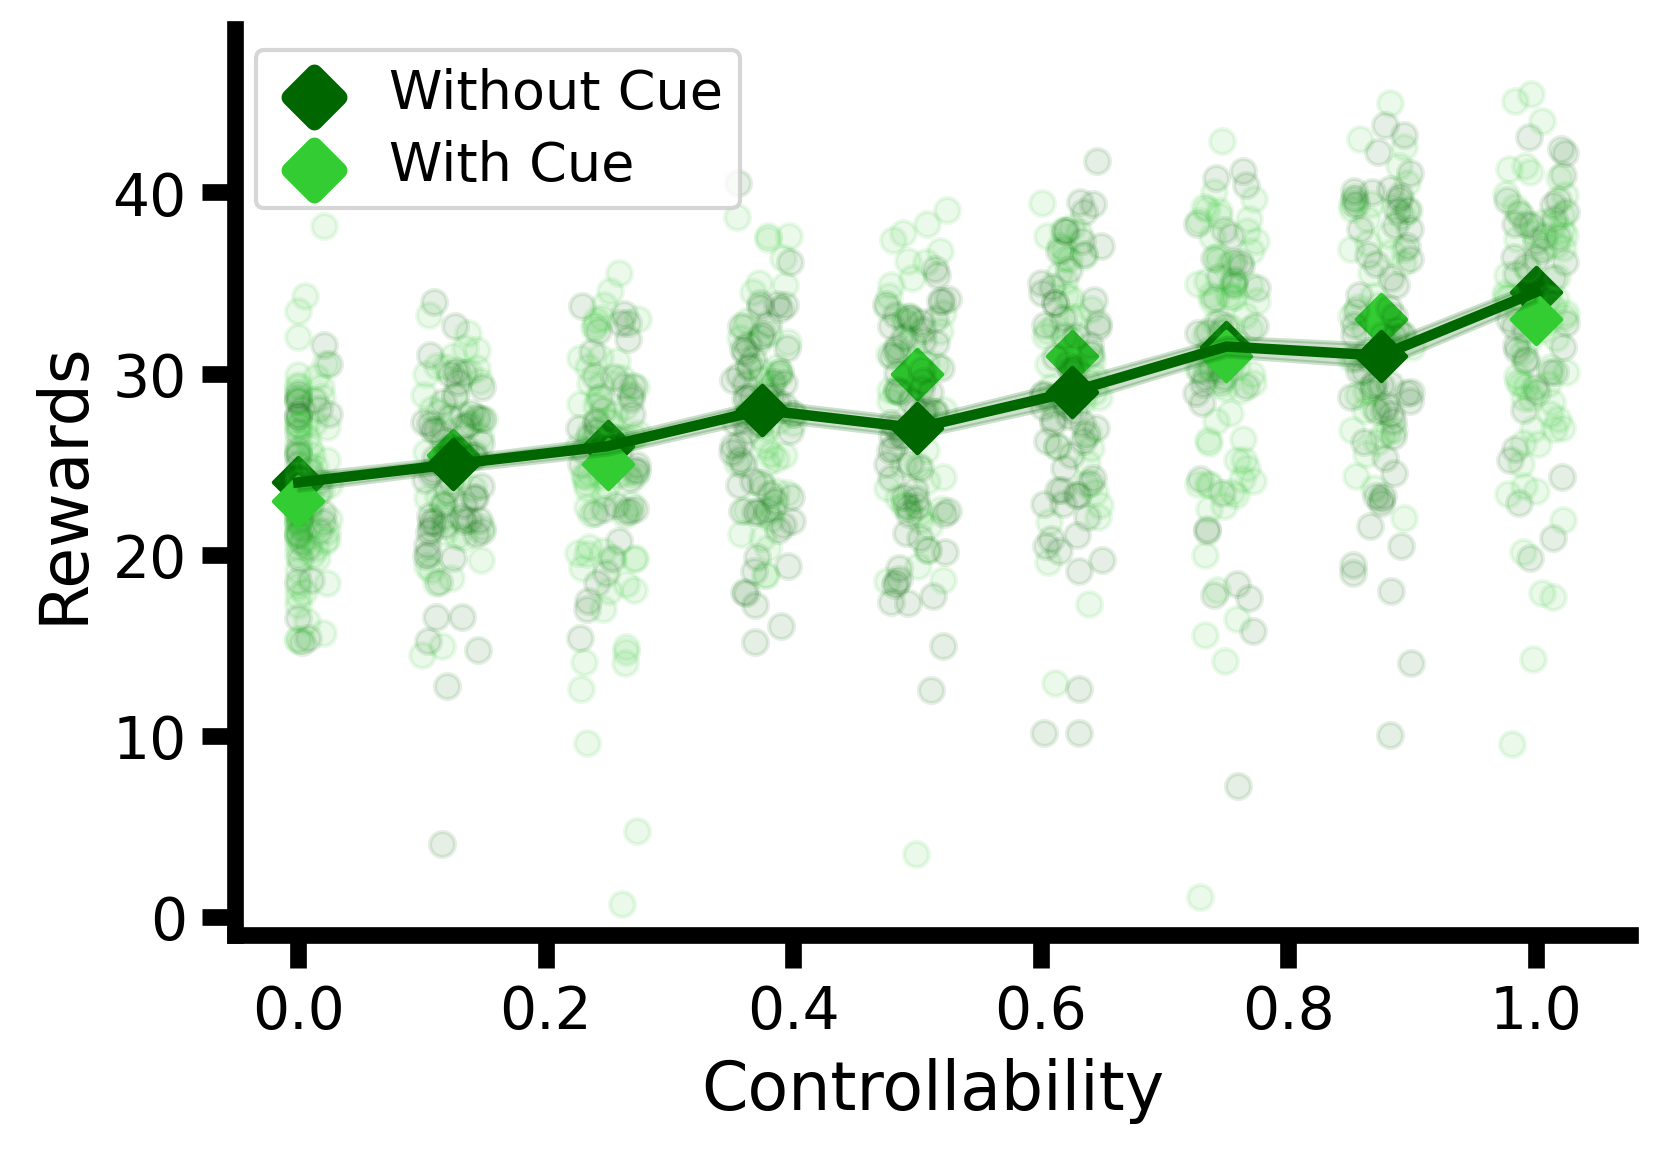

In [68]:
from human_plot_traj_analyses import plot_line_scatter_group

fig = plot_line_scatter_group((n_testA, n_testB), effs_test, (n_trainA, n_trainB), effs_train, ylabel='Rewards', ylim=ylim, xjitter=0.025, yjitter=1, median_over_mean=True,)

In [69]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_humans.svg'))

#### Stats

In [16]:
selected_rewards_tallies = [n_testA[:,-1], n_testB[:,2], n_testA[:,0]]

In [17]:
## MEANS AND SEMS
for level, rewards in zip(plotted_levels, selected_rewards_tallies):
    print("Test Controllability ", level)
    print("Mean ", rewards.mean())
    print("StdErr ", rewards.std()/np.sqrt(rewards.shape[0]))
    print("N", rewards.shape[0])

Test Controllability  1
Mean  33.82608695652174
StdErr  0.8482743228860326
N 46
Test Controllability  0.5
Mean  26.70769230769231
StdErr  0.6899869056035883
N 65
Test Controllability  0
Mean  24.02173913043478
StdErr  0.5820967335557214
N 46


In [18]:
## TUKEY'S
groups = flatten([[level]*len(obs) for level, obs in zip(plotted_levels, selected_rewards_tallies)])

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=flatten(selected_rewards_tallies), groups=groups, alpha=0.05)

# Print the results
print(tukey_result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   0.0    0.5    2.686 0.0238 0.2902 5.0817   True
   0.0    1.0   9.8043    0.0 7.2117 12.397   True
   0.5    1.0   7.1184    0.0 4.7227 9.5141   True
--------------------------------------------------


In [19]:
from human_utils_behavioral_analysis import fit_mixed_effects_glm

glm = fit_mixed_effects_glm(df, 'rewards_tallies')
glm.summary()


/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/kai/anaconda3/envs/meta-torch/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: rewards_tallies
No. Observations: 999     Method:             REML           
No. Groups:       111     Scale:              32.2287        
Min. group size:  9       Log-Likelihood:     -3195.7374     
Max. group size:  9       Converged:          Yes            
Mean group size:  9.0                                        
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          24.148    0.503 47.964 0.000 23.161 25.135
C(group_C)[T.True] -1.376    0.548 -2.509 0.012 -2.451 -0.301
efficacy            9.516    0.557 17.099 0.000  8.425 10.607
Group Var           4.517    0.212                           
=============================================================

"""

### APE-trained Neural Networks

In [74]:
from settings_anal import levc_human_ape_models as ape_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_ape_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_apes = mpl.colormaps['Blues']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_ape, counterss_peeks_taus_ape, control_errss_taus_ape, counterss_sleeps_taus_ape, trajss_actions_taus_ape, trajss_logits_taus_ape, trajss_ps_taus_ape = load_modelrun_files(ape_models, traj_timestamp, ape=True, traj_base=traj_base, includes_sleep=True)

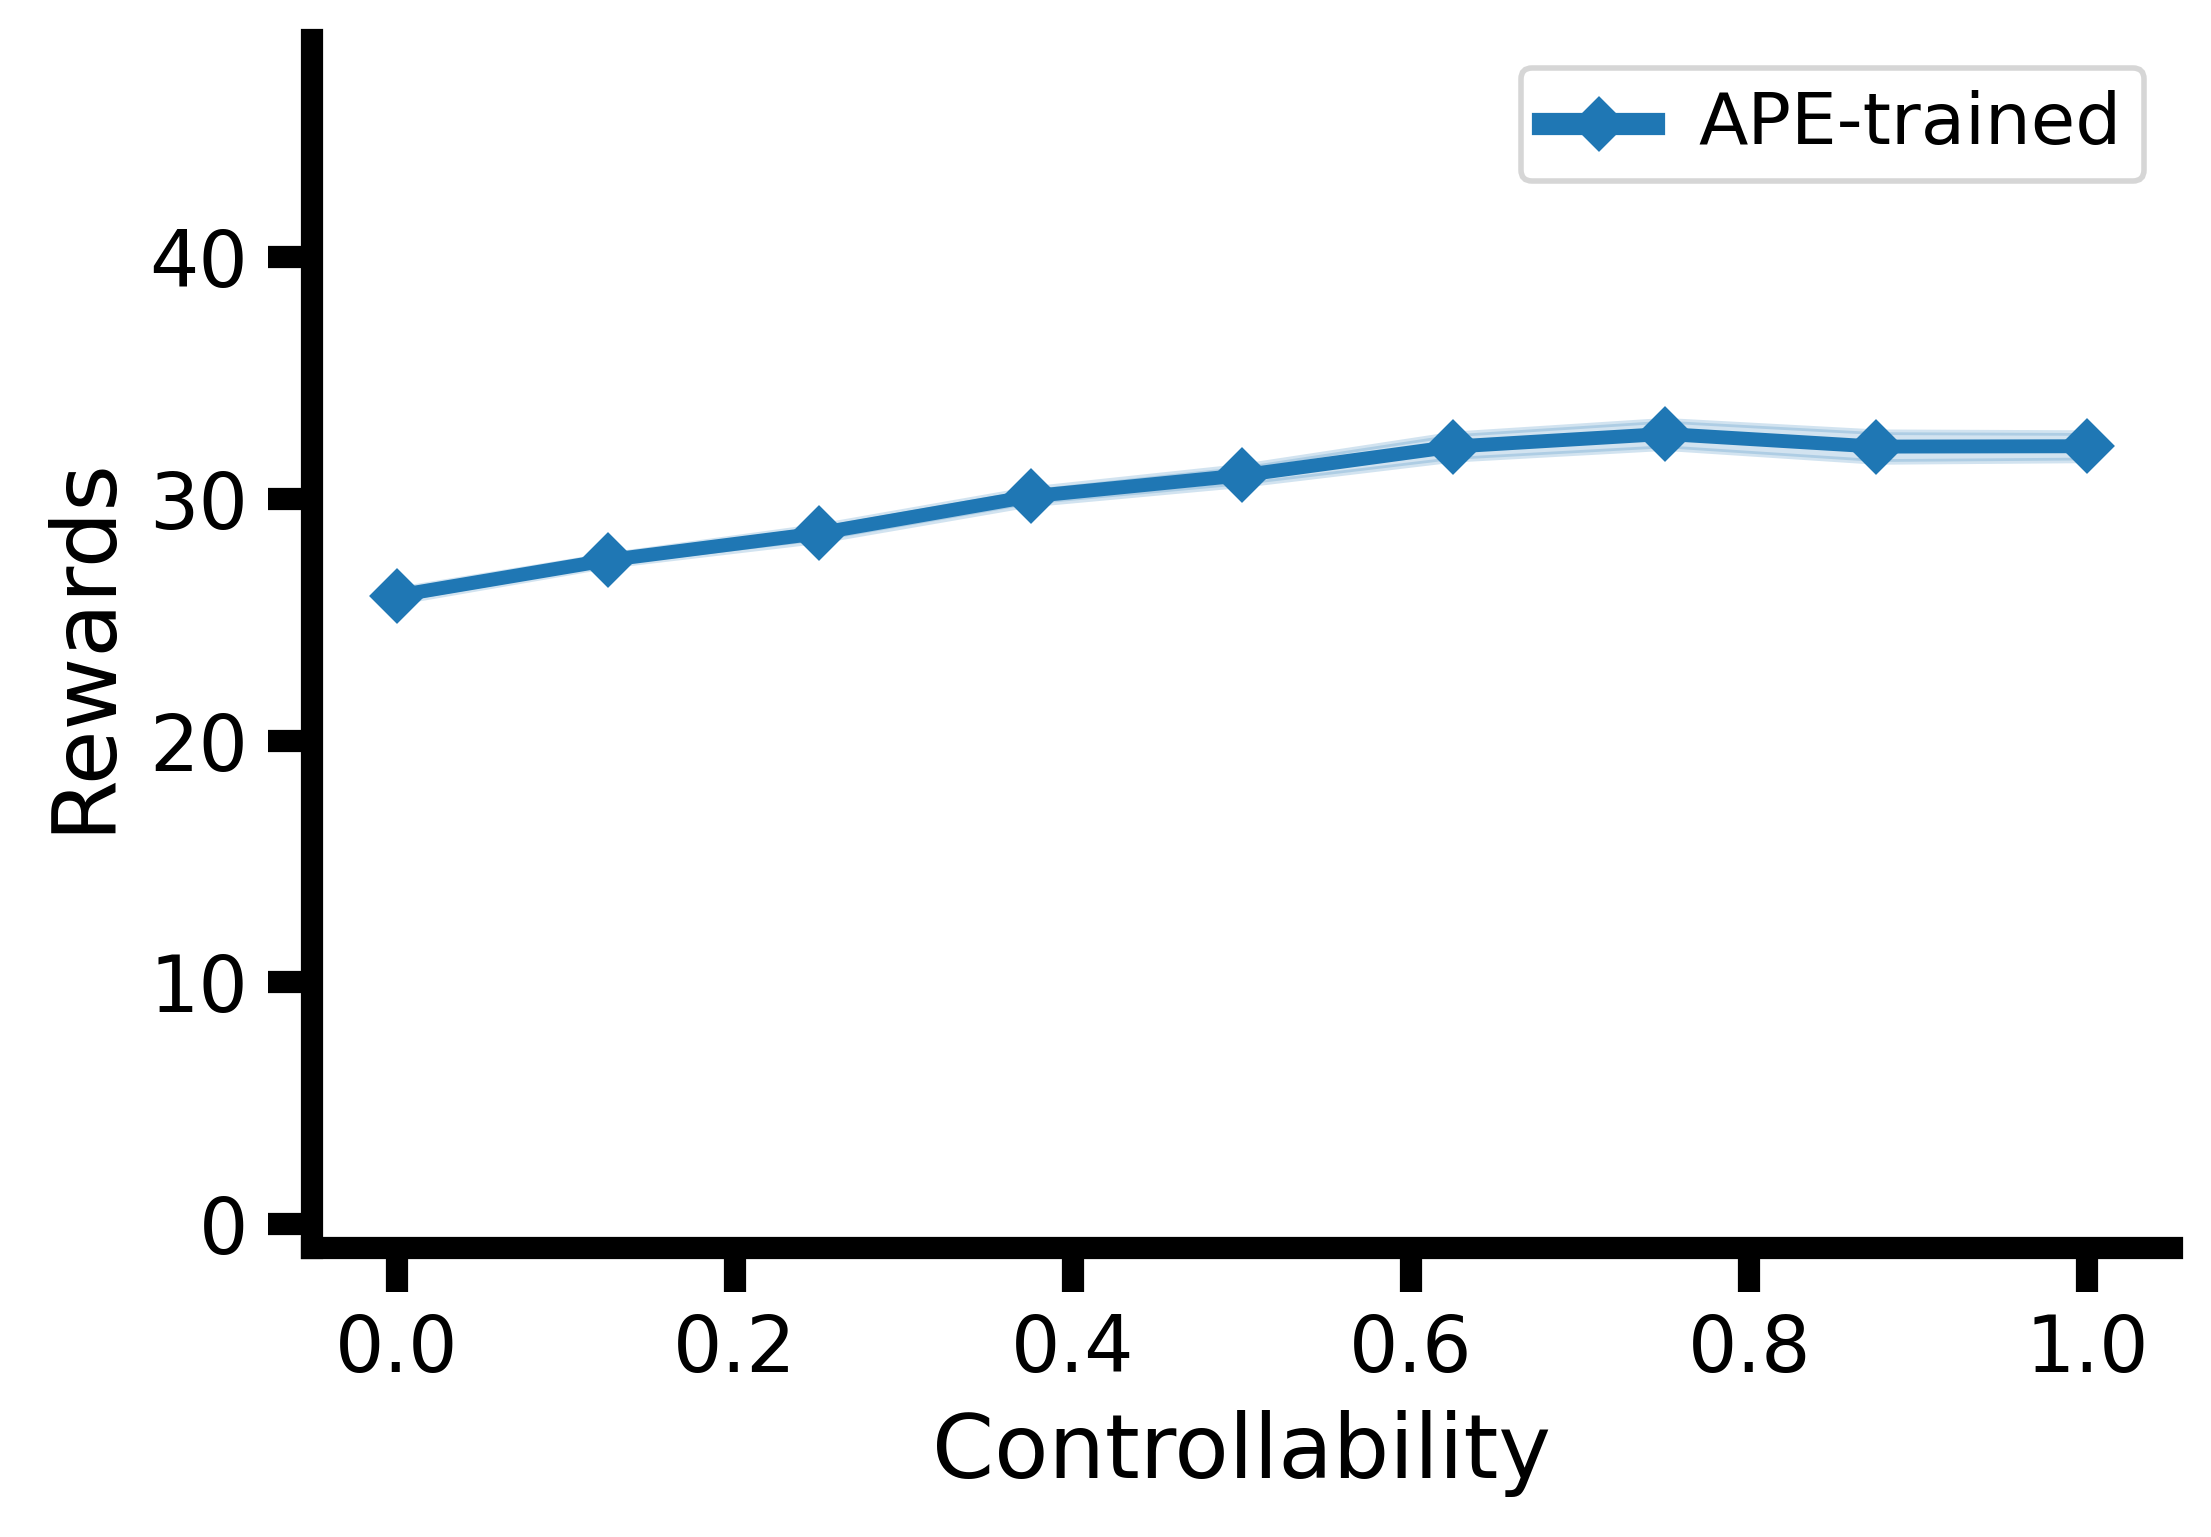

In [75]:
fig = plot_comparison_curves_several_runs(test_taus, list(reversed(rewss_taus_ape)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_exp='APE-trained', ylim=ylim, marker='D')

In [76]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_ape.svg'))

### No APE Neural Networks

In [77]:
from settings_anal import levc_human_control_models as control_models
from utils_project import load_modelrun_files
from settings_anal import levc_human_control_traj_timestamp as traj_timestamp

traj_base = os.path.join('data', 'eval', 'levc', )

cmap_control = mpl.colormaps['Oranges']
test_taus = np.arange(0, 1.1, 0.125)

rewss_taus_control, counterss_peeks_taus_control, _, counterss_sleeps_taus_control, trajss_actions_taus_control, trajss_logits_taus_control, trajss_ps_taus_control = load_modelrun_files(control_models, traj_timestamp, ape=False, traj_base=traj_base, includes_sleep=True)

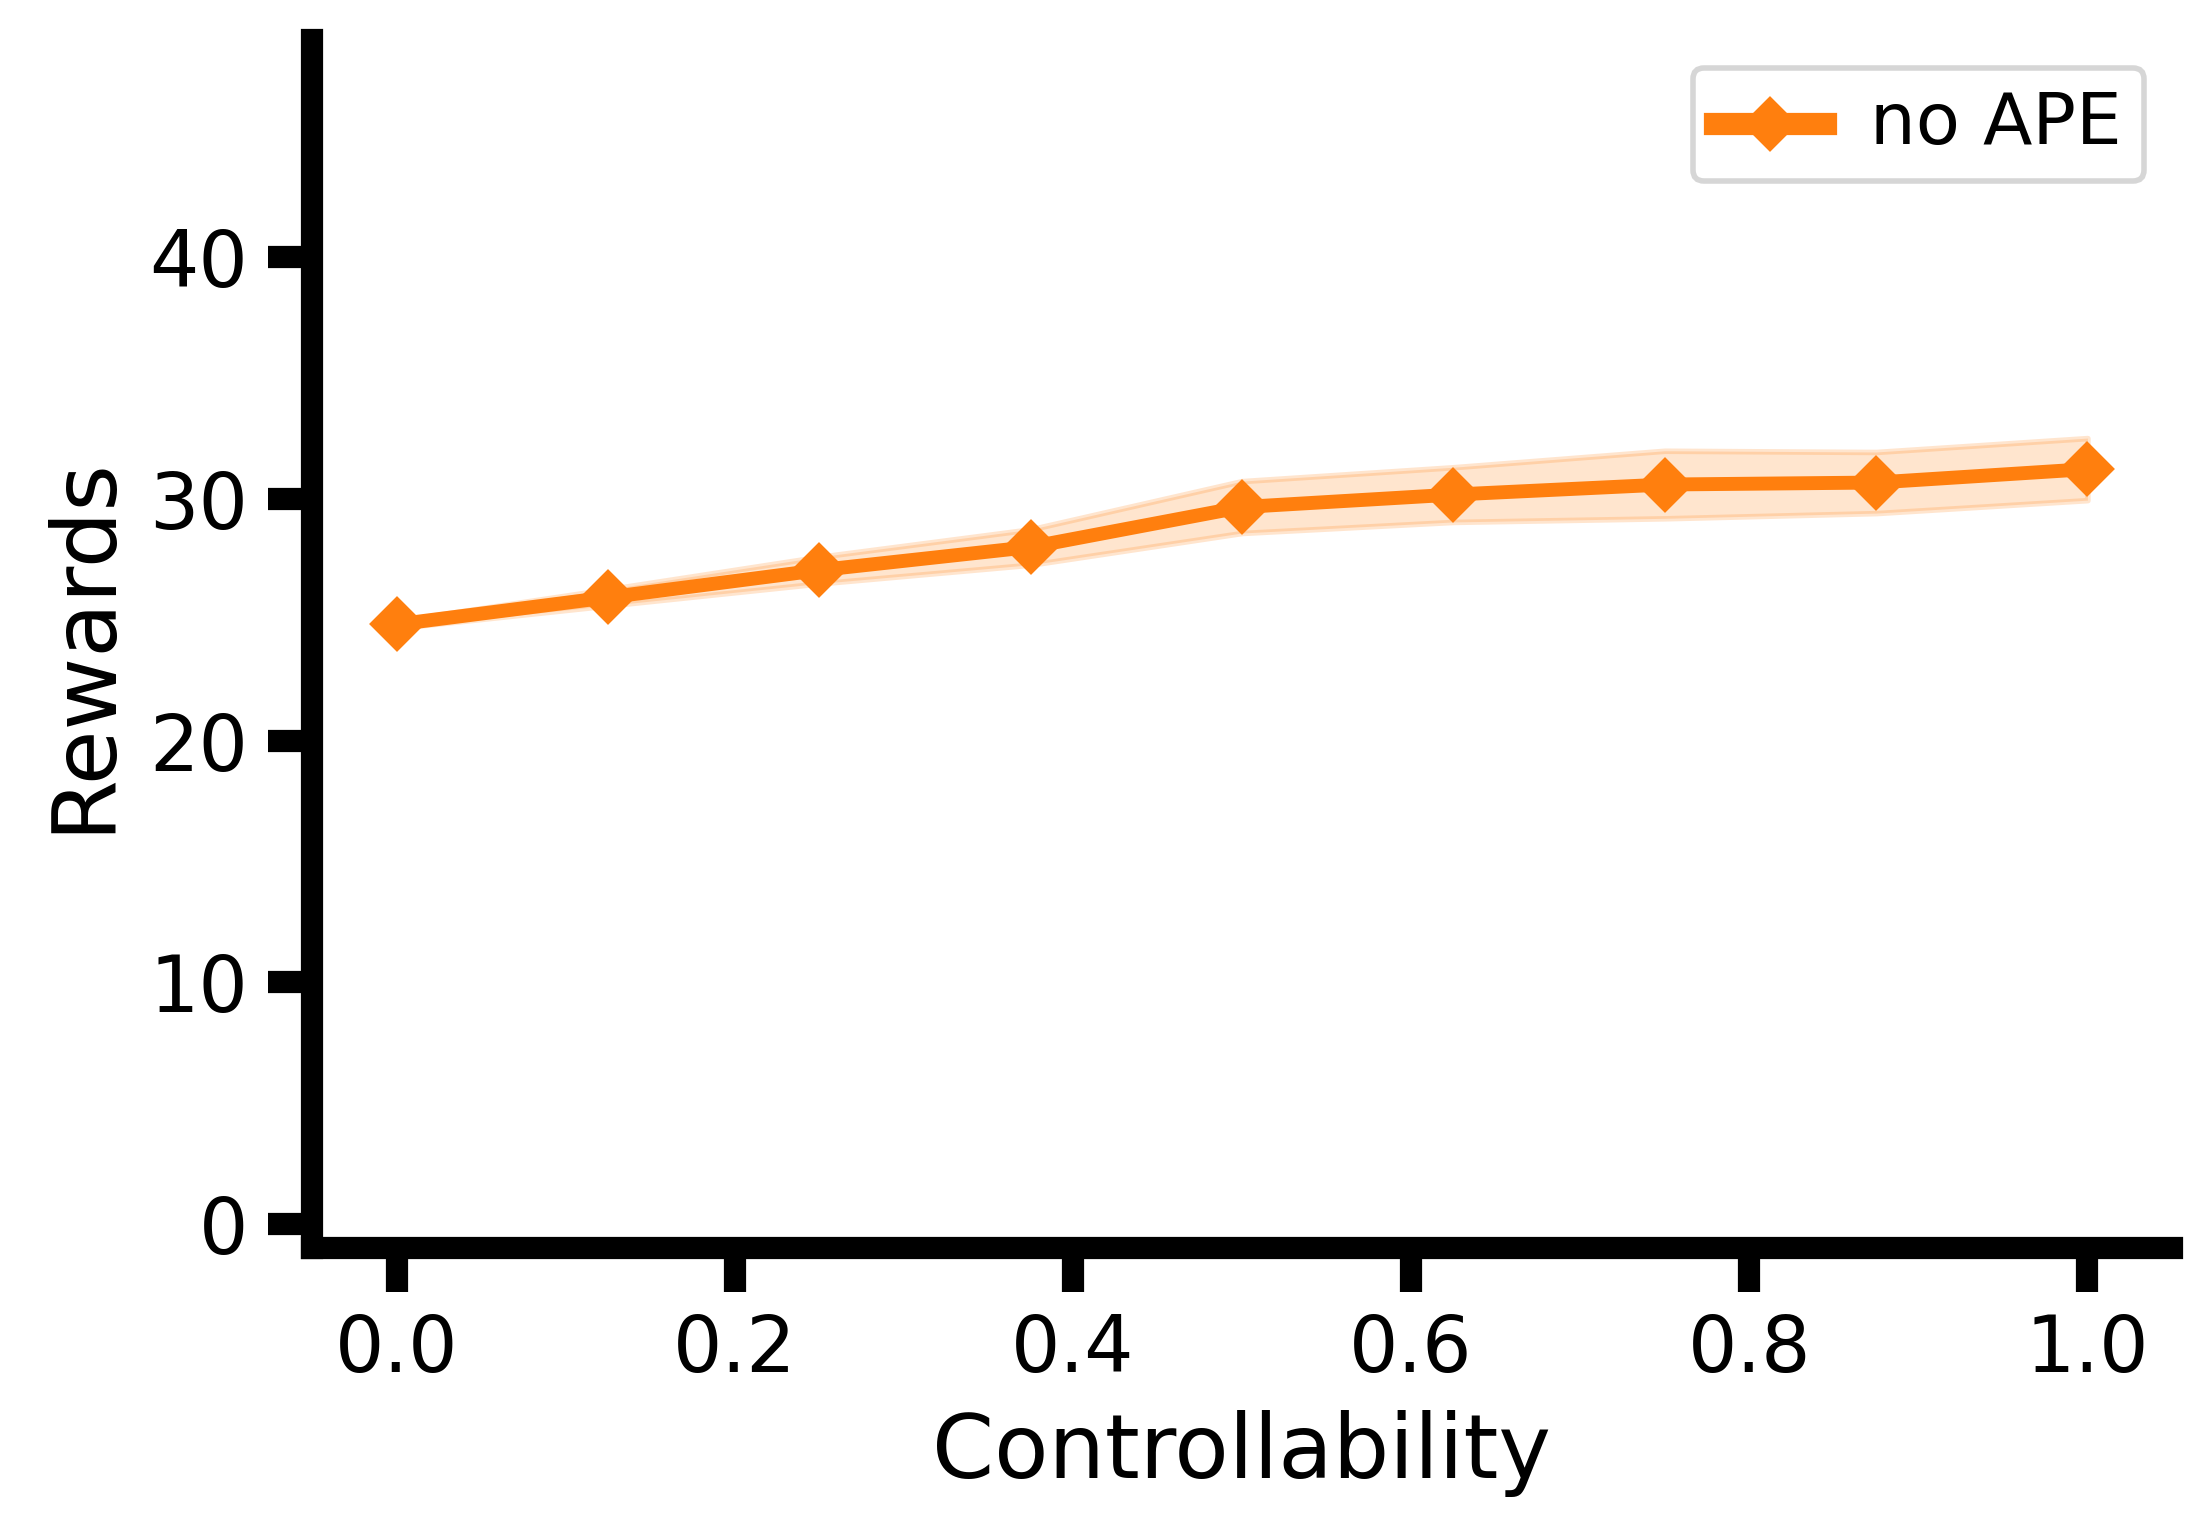

In [78]:
fig = plot_comparison_curves_several_runs(x_control=test_taus, y_control=list(reversed(rewss_taus_control)), axis_xlabel='Controllability', axis_ylabel='Rewards', label_control='no APE', ylim=ylim, marker='D')

In [79]:
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.png'))
fig.savefig(os.path.join(analysis_folder, 'rewards_across_noape.svg'))